In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.pylab.rcParams['figure.figsize'] = (10, 6)

In [3]:
def theurl(name):
 answer={"2012":"http://meps.ahrq.gov/mepsweb/data_stats/download_data_files_codebook.jsp?PUFId=H155", "2013":"http://meps.ahrq.gov/mepsweb/data_stats/download_data_files_codebook.jsp?PUFId=H163", "population": "http://meps.ahrq.gov/mepsweb/data_stats/download_data_files_codebook.jsp?PUFId=H157", "medical": "http://meps.ahrq.gov/mepsweb/data_stats/download_data_files_codebook.jsp?PUFId=H154", "risk": "http://meps.ahrq.gov/mepsweb/data_stats/download_data_files_codebook.jsp?PUFId=H140", "employment": "http://meps.ahrq.gov/mepsweb/data_stats/download_data_files_codebook.jsp?PUFId=H131", "jobs": "http://meps.ahrq.gov/mepsweb/data_stats/download_data_files_codebook.jsp?PUFId=H158", "person_round_plan": "http://meps.ahrq.gov/mepsweb/data_stats/download_data_files_codebook.jsp?PUFId=H153"}
 return answer[name]

In [4]:
def make_soup(url):
 response=requests.get(url)
 soup=BeautifulSoup(response.content)
 return soup

In [50]:
this=make_soup(theurl("2013"))

Querying this parser traverses the tree (truncated outut below):

In [55]:
this

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<html lang="en">
<head>
<meta content="The Medical Expenditure Panel Survey is a set of large-scale surveys of families and individuals, their medical providers, and employers across the United States." name="description"/>
<meta content="1/1/2006" name="created"/>
<meta content="8/1/2006" name="reviewed"/>
<meta content="Agency for Healthcare Research and Quality" name="author"/>
<meta content="en-us" http-equiv="Content-Language"/>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<title>Medical Expenditure Panel Survey PUF Codebook</title>
<link href="/mepsweb/css/meps_style.css" rel="stylesheet" type="text/css"/>
<script src="../js/menu_roll.js" type="text/javascript"></script>
<script language="JavaScript">
  function ClearNonPopupLinks() {  
   /*Replaces the href of all links to self + printer=yes to popup to Javascript:void(0) disabling them */
     for(var 

And it looks like the variable names and column limits are all contained in bits of the code that look like:

    <font class="smallBlack" face="Arial">CANCER DIAGNOSED - SKIN-NONMELANO (&gt;17)</font>,
    <font class="smallBlack" face="Arial">363   </font>,
    <font class="smallBlack" face="Arial">364   </font>,

The next function extracts all the tags in the parse tree with attribute "font" and collects them in a list, that I (in very poor taste) called final. In my defense, the list is really nothing, and nothing is ever final, so there you go.

I then use a helper function I called "prune_list" to get rid of the crud I didn't want to deal with that also happened to be part of a "font" tag. Finally, this function writes the code dictionary table to the file provided as the second argument to the function.

In [6]:
def get_data(soup,target):
 result=[]
 for row in soup.find_all("font"):
  result.append(row.contents)
 final=[(term[0].replace(u'\xa0',u'')).replace(',','') for term in result]
# get rid of junk
 final=prune_list(final,"::")
 final=prune_list(final,"MEPS HC-155")
 final=prune_list(final,"MEPS HC-163")
 final=prune_list(final,"MEPS HC-157")
 final=prune_list(final,"MEPS H154 CODEBOOK")
 final=prune_list(final,"MEPS H140 CODEBOOK")
 final=prune_list(final,"MEPS H131 CODEBOOK")
 final=prune_list(final,"MEPS HC-150")
 final=prune_list(final,"MEPS HC-158")
 final=prune_list(final,"MEPS H153 CODEBOOK")
 final=prune_list(final,"2012 FULL YEAR CONSOLIDATED DATA CODEBOOK")
 final=prune_list(final,"2013 FULL YEAR CONSOLIDATED DATA CODEBOOK")
 final=prune_list(final,"2013 FULL YEAR POPULATION CHARACTERISTICS CODEBOOK")
 final=prune_list(final,"2012 MEPS MEDICAL CONDITIONS FILE")
 final=prune_list(final,"2002-2009 RISK ADJUSTMENT SCORES FILE")
 final=prune_list(final,"EMPLOYMENT VARIABLE IMPUTATION FILE")
 final=prune_list(final,"2012 JOBS FILE CODEBOOK")
 final=prune_list(final,"2013 JOBS FILE CODEBOOK")
 final=prune_list(final,"2012 PERSON ROUND PLAN FILE")
 final=prune_list(final,"DATE:   August 25 2014")
 final=prune_list(final,"DATE:   August 25 2015")
 final=prune_list(final,"DATE: August 21 2014")
 final=prune_list(final,"DATE: August 4 2014")
 final=prune_list(final,"DATE:     March 6 2015")
 final=prune_list(final,"DATE: December 15 2014")
 final=prune_list(final,"DATE:    April 10 2013")
 final=prune_list(final,"DATE:   August 12 2014")
 final=prune_list(final,"DATE: February 13 2015")
 done=final
 with open(target,"w") as f:
  f.write("start,end,variable\n")
  for skip in range(0,len(final)-1,3):
   f.write("%s,"%final[skip])
   f.write("%s,"%final[skip+1])
   f.write("%s\n"%((final[skip+2]).lstrip()).rstrip())
 print("Done")
 temp=pd.read_csv(target)
 temp=temp.sort("start").copy()
 temp.index=list(range(len(temp)))
 return temp


Here's the definition of prune_list for reference:

In [7]:
def prune_list(thelist, theterm):
 while True:
  try:
   thelist.pop(thelist.index(theterm))
  except ValueError:
   break
 return thelist

Finally, here's the function that takes the MEPS dataset, and a dataframe containing the column dictionary, and writes the dataset out into a comma separated values file:

In [8]:
def write_table(data,header,target,short="No"):
 if short!="No":
  data=data[:10]
 data=prune_list(data,'')
 header=header.sort("start").copy()
 header.index=list(range(len(header)))
 with open(target,"w") as f:
  for element in header["variable"]:
   f.write("%s, "%element)
  f.write("\n")
 for row in data:
  u=[row[(header["start"].iloc[place]-1):(header["end"].iloc[place])] for place in header.index]
  with open(target,"a") as f:
   writer=csv.writer(f)
   writer.writerow(u)
  #print("Done with row %s"%data.index(row))


The next thing to do is to take a look at the dataset we have. Let's load it as a pandas dataframe and see what it contains:

In [9]:
cd ../../data/

/home/soumya/research/insight/insight_project/data


In [10]:
ls

2013_consolidated_frame.csv     2013_with_dummies_.pkl        dsm_data.pkl
2013_test_with_dummies.pkl      2013_with_dummies.pkl         Untitled.ipynb
2013_train_with_dummies.pkl     dsm_data_cleaned_columns.pkl
2013_validate_with_dummies.pkl  dsm_data.csv


In [11]:
data=pd.read_csv("./2013_consolidated_frame.csv")

First let's take a look at what features the dataset contains:

In [12]:
data.columns

Index(['DWELLING UNIT ID', ' PERSON NUMBER', ' PERSON ID (DUID + PID)',
       ' PANEL NUMBER', ' FAMILY ID (STUDENT MERGED IN) - R3/1',
       ' FAMILY ID (STUDENT MERGED IN) - R4/2',
       ' FAMILY ID (STUDENT MERGED IN) - R5/3',
       ' FAMILY ID (STUDENT MERGED IN) - 12/31/13',
       ' ANNUAL FAMILY IDENTIFIER', ' CPSFAMID', 
       ...
       ' TOTAL RX-PRV & TRI AMT 13', ' TOTAL RX-OTH COMBINED AMT 13',
       ' FINAL PERSON WEIGHT 2013', ' FINAL FAMILY WEIGHT 2013',
       ' POV ADJ FAMILY WGT-CPS FAM ON 12/31/13',
       ' FINAL SAQ PERSON WEIGHT 2013',
       ' FINAL DIABETES CARE SUPPLEMENT WEIGHT',
       ' VARIANCE ESTIMATION STRATUM - 2013',
       ' VARIANCE ESTIMATION PSU - 2013', ' '],
      dtype='object', length=1792)

The first thing I get from this is that I need to learn what these things mean. I'll probably have to look up the MEPS survey methodology or documentation in order to figure out what these features actually are.

The second thing I get out of looking at the column names is that they really do need a bit of cleanup. For example, the first feature is called "DWELLING UNIT ID", but the second is called " PERSON NUMBER" (note the extra space at the beginning). This seems to be a running problem in the column names.

How many of these column names do I need to fix?

In [13]:
len(data.columns)

1792

Ok, that's far too many to clean up by hand.

On the other hand, it looks like the cleanup consists of a couple of simple rules:

1. Remove the initial space in the feature name
2. Pop the last entry from the column names

Let's write a function to do the first job:

In [14]:
def clean_columns(theframe):
 temp=theframe.columns.map(lambda x: (((str(x).lstrip()).rstrip()))).copy()
 theframe.columns=temp.copy()
 return theframe

In [15]:
clean_columns(data)

,DWELLING UNIT ID,PERSON NUMBER,PERSON ID (DUID + PID),PANEL NUMBER,FAMILY ID (STUDENT MERGED IN) - R3/1,FAMILY ID (STUDENT MERGED IN) - R4/2,FAMILY ID (STUDENT MERGED IN) - R5/3,FAMILY ID (STUDENT MERGED IN) - 12/31/13,ANNUAL FAMILY IDENTIFIER,CPSFAMID,...,TOTAL RX-PRV & TRI AMT 13,TOTAL RX-OTH COMBINED AMT 13,FINAL PERSON WEIGHT 2013,FINAL FAMILY WEIGHT 2013,POV ADJ FAMILY WGT-CPS FAM ON 12/31/13,FINAL SAQ PERSON WEIGHT 2013,FINAL DIABETES CARE SUPPLEMENT WEIGHT,VARIANCE ESTIMATION STRATUM - 2013,VARIANCE ESTIMATION PSU - 2013,
0,20004,101,20004101,17,A,A,A,A,A,A,...,0,0,6594.801768,6263.398994,6263.398994,7960.062940,0.000000,1109,1,NaN
1,20004,102,20004102,17,A,A,A,A,A,A,...,0,0,7144.183132,6263.398994,6263.398994,7971.337575,0.000000,1109,1,NaN
2,20004,103,20004103,17,A,A,A,A,A,A,...,77,0,5616.278666,6263.398994,6263.398994,0.000000,0.000000,1109,1,NaN
3,20005,101,20005101,17,A,A,A,A,A,A,...,0,53,4045.586998,6080.690177,6080.690177,5604.764494,0.000000,1109,2,NaN
4,20005,102,20005102,17,A,A,A,A,A,A,...,0,0,6901.505814,6080.690177,6080.690177,7781.609891,0.000000,1109,2,NaN
5,20005,103,20005103,17,A,A,A,A,A,A,...,0,0,7510.348195,6080.690177,0.000000,7913.308819,0.000000,1109,2,NaN
6,20006,101,20006101,17,A,A,A,A,A,A,...,0,0,1579.090762,1662.637092,1662.637092,2774.336686,0.000000,1045,2,NaN
7,20006,102,20006102,17,A,A,A,A,A,A,...,0,0,1754.557897,1662.637092,1662.637092,2775.057769,0.000000,1045,2,NaN
8,20006,103,20006103,17,A,A,A,A,A,A,...,0,0,1798.211205,1662.637092,1662.637092,0.000000,0.000000,1045,2,NaN
9,20006,104,20006104,17,A,A,A,A,A,A,...,0,0,2119.474804,1662.637092,1662.637092,3268.594748,0.000000,1045,2,NaN


So far so good; now I just need to get rid of the last column.

In [16]:
data1=data.copy()
temp=list(data1.columns)
temp.pop()
temp[-10:]
temp.append("nothing")

In [17]:
data1.columns=temp

In [18]:
data1.drop("nothing", axis=1)

,DWELLING UNIT ID,PERSON NUMBER,PERSON ID (DUID + PID),PANEL NUMBER,FAMILY ID (STUDENT MERGED IN) - R3/1,FAMILY ID (STUDENT MERGED IN) - R4/2,FAMILY ID (STUDENT MERGED IN) - R5/3,FAMILY ID (STUDENT MERGED IN) - 12/31/13,ANNUAL FAMILY IDENTIFIER,CPSFAMID,...,TOT RX-OTH UNCLASS SRCE AMT 13,TOTAL RX-PRV & TRI AMT 13,TOTAL RX-OTH COMBINED AMT 13,FINAL PERSON WEIGHT 2013,FINAL FAMILY WEIGHT 2013,POV ADJ FAMILY WGT-CPS FAM ON 12/31/13,FINAL SAQ PERSON WEIGHT 2013,FINAL DIABETES CARE SUPPLEMENT WEIGHT,VARIANCE ESTIMATION STRATUM - 2013,VARIANCE ESTIMATION PSU - 2013
0,20004,101,20004101,17,A,A,A,A,A,A,...,0,0,0,6594.801768,6263.398994,6263.398994,7960.062940,0.000000,1109,1
1,20004,102,20004102,17,A,A,A,A,A,A,...,0,0,0,7144.183132,6263.398994,6263.398994,7971.337575,0.000000,1109,1
2,20004,103,20004103,17,A,A,A,A,A,A,...,0,77,0,5616.278666,6263.398994,6263.398994,0.000000,0.000000,1109,1
3,20005,101,20005101,17,A,A,A,A,A,A,...,0,0,53,4045.586998,6080.690177,6080.690177,5604.764494,0.000000,1109,2
4,20005,102,20005102,17,A,A,A,A,A,A,...,0,0,0,6901.505814,6080.690177,6080.690177,7781.609891,0.000000,1109,2
5,20005,103,20005103,17,A,A,A,A,A,A,...,0,0,0,7510.348195,6080.690177,0.000000,7913.308819,0.000000,1109,2
6,20006,101,20006101,17,A,A,A,A,A,A,...,0,0,0,1579.090762,1662.637092,1662.637092,2774.336686,0.000000,1045,2
7,20006,102,20006102,17,A,A,A,A,A,A,...,0,0,0,1754.557897,1662.637092,1662.637092,2775.057769,0.000000,1045,2
8,20006,103,20006103,17,A,A,A,A,A,A,...,0,0,0,1798.211205,1662.637092,1662.637092,0.000000,0.000000,1045,2
9,20006,104,20006104,17,A,A,A,A,A,A,...,0,0,0,2119.474804,1662.637092,1662.637092,3268.594748,0.000000,1045,2


Great, that worked. Alright, let's roll that into a function:

In [19]:
def pop_final_column(data):
 temp=list(data.columns)
 temp.pop()
 temp.append("nothing")
 data.columns=temp
 data=data.drop("nothing", axis=1)
 return data

In [20]:
data=pop_final_column(data)

In [21]:
data.columns

Index(['DWELLING UNIT ID', 'PERSON NUMBER', 'PERSON ID (DUID + PID)',
       'PANEL NUMBER', 'FAMILY ID (STUDENT MERGED IN) - R3/1',
       'FAMILY ID (STUDENT MERGED IN) - R4/2',
       'FAMILY ID (STUDENT MERGED IN) - R5/3',
       'FAMILY ID (STUDENT MERGED IN) - 12/31/13', 'ANNUAL FAMILY IDENTIFIER',
       'CPSFAMID', 
       ...
       'TOT RX-OTH UNCLASS SRCE AMT 13', 'TOTAL RX-PRV & TRI AMT 13',
       'TOTAL RX-OTH COMBINED AMT 13', 'FINAL PERSON WEIGHT 2013',
       'FINAL FAMILY WEIGHT 2013', 'POV ADJ FAMILY WGT-CPS FAM ON 12/31/13',
       'FINAL SAQ PERSON WEIGHT 2013', 'FINAL DIABETES CARE SUPPLEMENT WEIGHT',
       'VARIANCE ESTIMATION STRATUM - 2013', 'VARIANCE ESTIMATION PSU - 2013'],
      dtype='object', length=1791)

Perfect.

One thing worth remarking on is that I've actually extracted the variable **description** rather than the variable name in this step. This was a deliberate decision, as it's much easier to work with variable names like "MOST RECENT COLONOSCOPY (>39) - R5/3" rather than the variable name "CLNTST53". Those amongst you that are familiar with the constraints of variable names in SQL databases will already object that this is going to cause trouble in the future. I decided to go with the more descriptive variable names, and write a coding-decoding function to help move data in and out of SQL databases a bit later in the project. Overall, I think this was a reasonable choice.

Next, I'd like to learn a bit more about what these features are. The main thing to keep in mind is that having a large number of features will make our model very unwieldy. 

In the first instance, I'd really like the model to be **useful**, and if I have to collect 1700 features or so about a person before I can give them any useful feedback, this model won't be used by anyone.

Secondly, for the purposes of my project, I'm most concerned with what a much more restricted set of features say about billed charges. I'd really like to know how the demographic, economic, or idiosyncratic health status of a consumer drive cost, since these are the things that can inform how we choose to design the market for healthcare services.



To this end, let's take a look at what's available at http://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-163 . This page gives us two helpful pieces of information: the first is the documentation for the dataset [http://meps.ahrq.gov/mepsweb/data_stats/download_data/pufs/h163/h163doc.shtml] and the second is the codebook, which we've already used in constructing the csv file.

While the codebook contains the entire listing of variables in the dataset and the start-end points in the ASCII file, it does not tell us what the variables actually record. To be fair, the variable names are fairly descriptive, but a quick query of one of the columns in the dataset we've constructed:



In [22]:
data["HIGH CHOLESTEROL DIAGNOSIS (>17)"].describe()

count    36940.000000
mean         0.928533
std          1.355903
min         -9.000000
25%         -1.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: HIGH CHOLESTEROL DIAGNOSIS (>17), dtype: float64

raises the question: what do the values of this variable mean? It has a max of 2, and a min of -9. That doesn't correspond to any prior I currently have over the values of a diagnosis of high cholesterol. Let's take a more detailed look:

In [23]:
data["HIGH CHOLESTEROL DIAGNOSIS (>17)"].value_counts()

 2    18967
-1    10382
 1     7497
-8       49
-7       24
-9       21
dtype: int64

The most frequently populated values are 2, 1 and -1, but there are also records with values -8, -7 and -9.

This warrants a closer look at the documentation. A quick search for "cholesterol" turns up:

    High Cholesterol

    Questions about high cholesterol were asked of persons aged 18 or older. Consequently, persons aged 17 or younger were coded as “Inapplicable” (-1) on these variables. CHOLDX ascertained whether the person had ever been diagnosed as having high cholesterol. Through 2007, a person-level variable (CHLAGE) indicated the age of diagnosis for high cholesterol on the Person-Level Use PUF. The age of diagnosis for high cholesterol (CHOLAGED) is included in this file. This variable is top-coded to 85 years of age.



which is somewhat helpful, but doesn't explain the use of the values -8 and -9.

Further digging into the documentation yields the following table:

    2.2 Reserved Codes

    The following reserved code values are used:

    Value 	Definition
    -1 INAPPLICABLE 	Question was not asked due to skip pattern
    -2 DETERMINED IN PREVIOUS ROUND 	Question was not asked in round because there was no change in current main job since previous round
    -7 REFUSED 	Question was asked and respondent refused to answer question
    -8 DK 	Question was asked and respondent did not know answer
    -9 NOT ASCERTAINED 	Interviewer did not record the data
    -10 HOURLY WAGE >= $76.96 	Hourly wage was top-coded for confidentiality
    -13 INITIAL WAGE IMPUTED 	Hourly wage was previously imputed so an updated wage is not included in this file

This is helpful; it indicates that the most relevant levels for our analysis ought to be the following three:

1. Positive diagnosis of high cholesterol
2. Negative diagnosis of high cholesterol
3. Inapplicable to respondent

and given the low population in levels below -1, we can either aggregate these data points with level==-1, or discard them entirely. In the following analysis, we choose to discard them.

A final question that needs to be asked at this step is which level corresponds to a positive diagnosis of high cholesterol? A close look at the documentation indicates that level==1 corresponds to having the condition, and level==2 corresponds to not having the condition. Knowing which level is which doesn't particularly affect the computations that generate our models going forward, but it is important for being able to interpret the models.

As a quick sanity check, let's get a visualization of the distribution of the data between these levels:

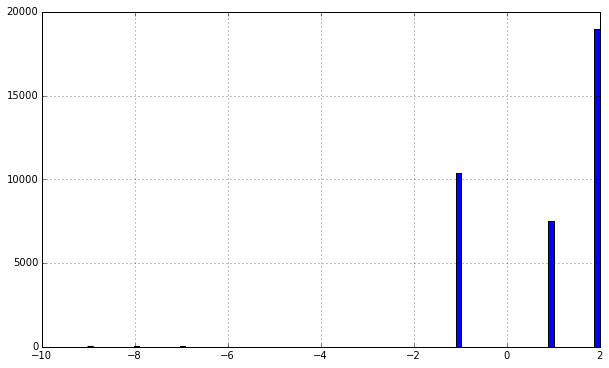

In [24]:
data["HIGH CHOLESTEROL DIAGNOSIS (>17)"].hist(bins=100)

Of the respondents for whom the question was applicable, it looks like the ratio of level==1 to level==2 is 7/19 or about 1/3. This is close to the CDC estimates of the prevalence of high cholesterol amongst American adults: http://www.cdc.gov/dhdsp/data_statistics/fact_sheets/fs_cholesterol.htm .

That visualization was a nice way of learning something about the data, and confirming a hunch we had about how to interpret it. In fact, simple visual plots of different features in the dataset are a crucial way of getting some initial insight into the data, and helping us prioritize the most fruitful approaches for modeling the data.

To fix ideas, let's scope down what we want to go into our model.

Explicitly, we'd like to be able to answer the following questions: which (if any) of the following features about a person determine what they will pay for healthcare in a year?

1. Demographic information:
    1. Age
    2. Sex
    3. Race/Ethnicity
    4. Marital Status
    5. Educational attainment
    6. Census region
2. Income information (these are all top-coded in the dataset for confidentiality reasons):
3. Idiosyncratic health status variables:
    1. High blood pressure, including multiple diagnoses
    2. Heart disease (including coronary heart disease, angina, myocardial infarction, and other unspecified heart disease)
    3. Stroke
    4. Emphysema
    5. Chronic Bronchitis
    6. High cholesterol, including the age of diagnosis
    7. Cancer
    8. Diabetes
    9. Joint pain
    10. Arthritis
    11. Asthma
    12. Attention Deficit Hyperactivity Disorder/Attention Deficit Disorder (ADHD/ADD)
4. Preventative care variables:
    1. DENTCK53 – on average, frequency of dental check-up
    2. BPCHEK53 – how long since last blood pressure check
    3. CHOLCK53 – about how long since last blood cholesterol check by doctor or health professional
    4. CHECK53 – how long since last routine check-up by doctor or other health professional for assessing overall health
    5. NOFAT53 – has a doctor or other health professional ever advised the person to eat fewer high fat or high cholesterol foods
    6. EXRCIS53 – has a doctor advised the person to exercise more
    7. FLUSHT53 – how long since last flu vaccination
    8. ASPRIN53 – does the person take aspirin frequently
    9. NOASPR53 – is taking aspirin unsafe due to a medical condition
    10. STOMCH53 – is taking aspirin unsafe due to a stomach-related reason or something else
    11. LSTETH53 – has person lost all natural (permanent) teeth
    12. PSA53 – how long since last prostate specific antigen (PSA) test
    13. HYSTER53 – had a hysterectomy
    14. PAPSMR53 – how long since last pap smear test
    15. BRSTEX53 – how long since last breast exam
    16. MAMOGR53 – how long since last mammogram
    17. BSTST53 – when last blood stool test using the home kit
    18. BSTSRE53 – reason for blood stool test
    19. CLNTST53 – when last colonoscopy
    20. CLNTRE53 – reason for colonoscopy
    21. SGMTST53 – when last sigmoidoscopy
    22. SGMTRE53 – reason for sigmoidoscopy
    23. PHYEXE53 – currently spends half hour or more in moderate to vigorous physical activity at least five times a week
    24. BMINDX53 – Adult Body Mass Index (BMI) as based on reported height and weight
    25. SEATBE53 – wears seat belt when drives or rides in a car
5. Adult Body Mass Index
6. Health Insurance Variables
    1. Public Insurance Indicators
    2. Private Insurance Indicators
    3. Any Insurance Indicators
    4. HMO plan
7. Utilization, expenditure and source of payments information

It's fair to say that this is a lot of information to process. One thing that stands out here is that there are a great number of features already recorded for us in this dataset; this is in sharp contrast to some projects I've done using text and/or social media data, in which a crucial part of the modeling process is feature construction in some appropriate way.

Since there is such a rich variety of features, I imagine most of the feature engineering in this project will amount to bucketing variables and levels in appropriate ways to optimize explained variation, rather than constructing new features from scratch.

To this end, let's make a list of the exact features we want to start working with.

1. Age as of 12/31/13 (Edited/Imputed)
2. Sex
3. Race (Edited/Imputed)
4. Marital Status–12/31/13 (Edited/Imputed)
5. Marital Status w/Spouse Present–12/31/13
6. EDUCATION RECODE (EDITED)
7. Family’s Total Income
8. High Blood Pressure Diag (>17)
9. Coronary Hrt Disease Diag (>17)
10. Age of Diagnosis-High Blood Pressure
11. Mult Diag High Blood Press (>17) 	
12. Coronary Hrt Disease Diag (>17) 	
13. Age of Diagnosis–Coronary Heart Disease 	
14. Angina Diagnosis (>17) 	
15. Age of Diagnosis-Angina 	
16. Heart Attack (MI) Diag (>17) 	
17. Age of Diagnosis-Heart Attack (MI) 	
18. Other Heart Disease Diag (>17) 	
19. Age of Diagnosis-Other Heart Disease 	
20. Stroke Diagnosis (>17) 	
21. Age of Diagnosis-Stroke 	
22. Emphysema Diagnosis (>17) 	
23. Age of Diagnosis-Emphysema 	
24. Chronc Bronchits Last 12 Mths (>17)–R3/1 	
25. Chronc Bronchits Last 12 Mths (>17)–R5/3 	
26. High Cholesterol Diagnosis (>17) 	
27. Age of Diagnosis-High Cholesterol 	
28. Cancer Diagnosis (>17) 	
29. Cancer Diagnosed - Bladder (>17)
30. Cancer Diagnosed - Breast (>17) 	
31. Cancer Diagnosed - Cervix (>17) 	
32. Cancer Diagnosed - Colon (>17) 	
33. Cancer Diagnosed - Lung (>17) 	
34. Cancer Diagnosed - Lymphoma (>17) 	
35. Cancer Diagnosed - Melanoma (>17) 	
36. Cancer Diagnosed - Other (>17) 	
37. Cancer Diagnosed - Prostate (>17) 	
38. Cancer Diagnosed – Skin-Nonmelano (>17) 	
39. Cancer Diagnosed – Skin-Unknown Type (>17) 	
40. Cancer Diagnosed - Uterus (>17) 	
41. Diabetes Diagnosis (>17) 	
42. Age of Diagnosis-Diabetes 	
43. Joint Pain Last 12 Months (>17) – RD 3/1 	
44. Joint Pain Last 12 Months (>17) – RD 5/3 	
45. Arthritis Diagnosis (>17) 	
46. Type Of Arthritis Diagnosed (>17) 	
47. Age of Diagnosis-Arthritis 	
48. Asthma Diagnosis 	
49. Age of Diagnosis-Asthma 	
50. Does Person Still Have Asthma – RD 3/1 	
51. Does Person Still Have Asthma - RD 5/3 	
52. Asthma Attack Last 12 Mos– RD 3/1 	
53. Asthma Attack Last 12 Mos– RD 5/3 	
54. When Was Last Episode Of Asthma – Rd 3/1 	
55. When Was Last Episode Of Asthma – Rd 5/3 	
56. Used Acute Pres Inhaler Last 3 Mos-RD5/3 	
57. Used >3Acute Cn Pres Inh Last 3 Mos-RD5/3 	
58. Ever Used Prev Daily Asthma Meds -RD5/3 	
59. Now Take Prev Daily Asthma Meds - RD 5/3 	
60. Have Peak Flow Meter at Home – RD 5/3 	
61. Ever Used Peak Flow Meter - RD 5/3 	
62. When Last Used Peak Flow Meter - RD 5/3 	
63. ADHD/ADD Diagnosis (5-17) 	
64. Age of Diagnosis-ADHD/ADD
65. Pregnant During Ref Period – RD 3/1 	
66. Limitation in Physical Functioning – RD 3/1
67. Employment Status RD 3/1
68. Has More than One Job RD 3/1 Int Date
69. Self-Employed at RD 3/1 CMJ
70. Choice of Health Plans at RD 3/1 CMJ
71. Industry Group RD 3/1 CMJ
72. Union Status at RD 3/1 CMJ
73. Occupation Group RD 3/1 CMJ
74. Health Insur Held from RD 3/1 CMJ (Ed)
75. Health Insur Offered by RD 3/1 CMJ (Ed)
76. Employer Offers Health Ins RD 3/1 CMJ
77. Full Year Insurance Coverage Status 2013
78. Anyone in RU Have FSA
79. \# Wks/Mon Wout Hlth Ins Prv Yr–Pnl 18 Onl
80. Private Insurance Any Time in R5/R3
81. Public Ins Any Time in R5/R3
82. Insured Any Time in R3/1
83. Any Time Coverage by State Ins - R3/1
84. \# Office-Based Provider Visits 2013
85. \# Outpatient Dept Provider Visits 2013
87. \# Emergency Room Visits 2013
89. \# Nights in Hosp for Discharges 2013
92. Final Person Weight, 2013
93. Census Region as of 12/31/13



Whew! That's a LOT of features! It's going to be extremely interesting to see if these have any explanatory power for the statistical variation in spending on healthcare!

Speaking of which, what are the variables we're trying to predict?

1. TOTAL OFFICE-BASED EXP 13
2. TOTAL OUTPATIENT PROVIDER EXP 13
3. TOT HOSP IP FACILITY + DR EXP 13
4. TOTAL ER FACILITY + DR EXP 13

The dataset breaks out healthcare expenses into these four location based categories: office, outpatient, inpatient and ER.

Another modeling choice that needs to be made is whether to try and predict total expenses, or predict each category of expense individually. In my Insight project, I opted to try and predict them individually, to see if I could shed some light on whether the service location affected prices charged. There's substantial reason to think this may be the case: ER sticker shock is widely reported in the news.

Finally, it's time to reflect a bit on what we've done here. We've isolated explanatory variables that we hope and expect should be predictive of how much a person is charged for healthcare services in four different categories. That's great, but there's a very large number of predictors: 87. Since the ultimate goal is to build a usable interface to the model that people can use to get a sense of their expected outlays on healthcare, it makes sense to refine and reduce this list. But how?

One way to think about this is to consider what information people are comfortable and likely to share about themselves that could help to predict expenses. Another is to focus on what the most predictive variables are, and then ask users to populate these variables in order to get a prediction. In my Insight project, I opted to balance both these concerns by ranking the explanatory variables in terms of statistical variance explained, cutting off at a reasonable threshold (somewhere in between 10 and 20 variables, corresponding to 10-20 questions asked of the user), and also culling variables that would be particularly burdensome to the user to have to report.

The next thing to think about is: now that we have explanatory variables and explained variables selected, how do we best go about building a model?

One thing to do is to examine the data feature by feature, to get a better sense of what it looks like and to pick up hunches for what may explain the variation.



First, let's look at the explained variables:

In [25]:
data["TOTAL OFFICE-BASED EXP 13"].describe()

count     36940.000000
mean        884.442799
std        3290.683088
min           0.000000
25%           0.000000
50%         156.000000
75%         653.000000
max      195295.000000
Name: TOTAL OFFICE-BASED EXP 13, dtype: float64

This is interesting. It looks like upto half of respondents (and by scaling out using the person weights, half of all Americans) spend less than \$200 for office-based services in a year. The maximum though, is concerning: over a hundred thousand dollars? Let's take a closer look at that.

In [26]:
data[data["TOTAL OFFICE-BASED EXP 13"]>=100000]

,DWELLING UNIT ID,PERSON NUMBER,PERSON ID (DUID + PID),PANEL NUMBER,FAMILY ID (STUDENT MERGED IN) - R3/1,FAMILY ID (STUDENT MERGED IN) - R4/2,FAMILY ID (STUDENT MERGED IN) - R5/3,FAMILY ID (STUDENT MERGED IN) - 12/31/13,ANNUAL FAMILY IDENTIFIER,CPSFAMID,...,TOT RX-OTH UNCLASS SRCE AMT 13,TOTAL RX-PRV & TRI AMT 13,TOTAL RX-OTH COMBINED AMT 13,FINAL PERSON WEIGHT 2013,FINAL FAMILY WEIGHT 2013,POV ADJ FAMILY WGT-CPS FAM ON 12/31/13,FINAL SAQ PERSON WEIGHT 2013,FINAL DIABETES CARE SUPPLEMENT WEIGHT,VARIANCE ESTIMATION STRATUM - 2013,VARIANCE ESTIMATION PSU - 2013
2384,21174,101,21174101,17,A,A,A,A,A,A,...,0,0,0,10189.789734,8764.276613,8764.276613,11832.982213,13517.344724,1007,1
2834,21386,102,21386102,17,A,A,A,A,A,A,...,0,16487,0,22234.388648,26645.022692,26645.022692,24377.214141,26657.263092,1065,1
15019,27647,105,27647105,17,A,A,A,A,A,A,...,0,173,0,16134.188642,6000.045922,6000.045922,0.000000,0.000000,1149,2
15659,27976,101,27976101,17,A,A,A,A,A,A,...,0,0,0,15650.765936,12480.521290,12480.521290,14907.860615,16293.073976,1140,1


There are 4 people with office based expenses of over 100k. I'd like to take a look to see if they're freak outliers, or if they should be kept in the dataset. My prior is that they should be kept in the dataset (the MEPS survey has been running for over 15 years by people who I can only assume know what they're doing). But it doesn't hurt to take a closer look.

I don't want to look at all the extra features in the dataset beyond those that I've decided I care about, so let's go about trimming the dataframe down to contain just these features.

As a matter of good practice, let's write the current dataset to a file, in case we break something and need to come back to this checkpoint.

In [27]:
data.to_pickle("./dsm_data_cleaned_columns.pkl")

In [28]:
cd /home/soumya/research/insight/insight_project/modeling/code/

/home/soumya/research/insight/insight_project/modeling/code


I've manually written the explanatory variables to a text file located at "/home/soumya/research/insight/insight_project/modeling/code/dsm_exog.txt". I'm going to read this into memory:

In [29]:
variables=[]
with open("dsm_exog.txt","r") as f:
    lines=f.readlines()
    for line in lines:
        variables.append(line.strip().upper())
print(variables)

['AGE AS OF 12/31/13 (EDITED/IMPUTED)', 'SEX', 'RACE (EDITED/IMPUTED)', 'MARITAL STATUS-12/31/13 (EDITED/IMPUTED)', 'MARITAL STATUS W/SPOUSE PRESENT-12/31/13', 'YEAR OF EDUCATION OR HIGHEST DEGREE', "FAMILY'S TOTAL INCOME", 'HIGH BLOOD PRESSURE DIAG (>17)', 'CORONARY HRT DISEASE DIAG (>17)', 'AGE OF DIAGNOSIS-HIGH BLOOD PRESSURE', 'MULT DIAG HIGH BLOOD PRESS (>17)', 'AGE OF DIAGNOSIS-CORONARY HEART DISEASE', 'ANGINA DIAGNOSIS (>17)', 'AGE OF DIAGNOSIS-ANGINA', 'HEART ATTACK (MI) DIAG (>17)', 'AGE OF DIAGNOSIS-HEART ATTACK(MI)', 'OTHER HEART DISEASE DIAG (>17)', 'AGE OF DIAGNOSIS-OTHER HEART DISEASE', 'STROKE DIAGNOSIS (>17)', 'AGE OF DIAGNOSIS-STROKE', 'EMPHYSEMA DIAGNOSIS (>17)', 'AGE OF DIAGNOSIS-EMPHYSEMA', 'CHRONC BRONCHITS LAST 12 MTHS (>17)-R3/1', 'CHRONC BRONCHITS LAST 12 MTHS (>17)-R5/3', 'HIGH CHOLESTEROL DIAGNOSIS (>17)', 'AGE OF DIAGNOSIS-HIGH CHOLESTEROL', 'CANCER DIAGNOSIS (>17)', 'CANCER DIAGNOSED - BLADDER (>17)', 'CANCER DIAGNOSED - BREAST (>17)', 'CANCER DIAGNOSED - CE

In [30]:
data[variables].head()

,AGE AS OF 12/31/13 (EDITED/IMPUTED),SEX,RACE (EDITED/IMPUTED),MARITAL STATUS-12/31/13 (EDITED/IMPUTED),MARITAL STATUS W/SPOUSE PRESENT-12/31/13,YEAR OF EDUCATION OR HIGHEST DEGREE,FAMILY'S TOTAL INCOME,HIGH BLOOD PRESSURE DIAG (>17),CORONARY HRT DISEASE DIAG (>17),AGE OF DIAGNOSIS-HIGH BLOOD PRESSURE,...,# OUTPATIENT DEPT PROVIDER VISITS 13,# EMERGENCY ROOM VISITS 13,# NIGHTS IN HOSP FOR DISCHARGES 2013,FINAL PERSON WEIGHT 2013,TOTAL OFFICE-BASED EXP 13,TOTAL OUTPATIENT PROVIDER EXP 13,TOT HOSP IP FACILITY + DR EXP 13,TOTAL ER FACILITY + DR EXP 13,CENSUS REGION AS OF 12/31/13,EDUCATION RECODE (EDITED)
0,39,1,1,1,1,5,85728,2,2,-1,...,0,0,0,6594.801768,428,0,0,0,3,14
1,40,2,1,1,1,4,85728,2,2,-1,...,0,0,0,7144.183132,0,0,0,0,3,13
2,10,2,1,6,3,1,85728,-1,-1,-1,...,2,0,0,5616.278666,0,108,0,0,3,1
3,52,1,1,4,2,5,20142,1,2,41,...,0,0,0,4045.586998,674,0,0,0,1,14
4,22,1,1,5,2,5,20142,2,2,-1,...,0,0,0,6901.505814,0,0,0,0,1,14


In [31]:
print(len(variables))
temp=[]
while variables!=[]:
    this=variables.pop()
    if this in temp:
        continue
    else:
        temp.append(this)
while temp!=[]:
    variables.append(temp.pop())
print(len(variables))

92
92


For future reference, let's write this dataset to disk so we don't have to do all this over again.

In [32]:
data[variables].to_pickle("../data/dsm_data_scoped_variables.pkl")

Let's check this worked:

In [33]:
data=pd.read_pickle("../data/dsm_data_scoped_variables.pkl")

In [34]:
data.head()

,AGE AS OF 12/31/13 (EDITED/IMPUTED),SEX,RACE (EDITED/IMPUTED),MARITAL STATUS-12/31/13 (EDITED/IMPUTED),MARITAL STATUS W/SPOUSE PRESENT-12/31/13,YEAR OF EDUCATION OR HIGHEST DEGREE,FAMILY'S TOTAL INCOME,HIGH BLOOD PRESSURE DIAG (>17),CORONARY HRT DISEASE DIAG (>17),AGE OF DIAGNOSIS-HIGH BLOOD PRESSURE,...,# OUTPATIENT DEPT PROVIDER VISITS 13,# EMERGENCY ROOM VISITS 13,# NIGHTS IN HOSP FOR DISCHARGES 2013,FINAL PERSON WEIGHT 2013,TOTAL OFFICE-BASED EXP 13,TOTAL OUTPATIENT PROVIDER EXP 13,TOT HOSP IP FACILITY + DR EXP 13,TOTAL ER FACILITY + DR EXP 13,CENSUS REGION AS OF 12/31/13,EDUCATION RECODE (EDITED)
0,39,1,1,1,1,5,85728,2,2,-1,...,0,0,0,6594.801768,428,0,0,0,3,14
1,40,2,1,1,1,4,85728,2,2,-1,...,0,0,0,7144.183132,0,0,0,0,3,13
2,10,2,1,6,3,1,85728,-1,-1,-1,...,2,0,0,5616.278666,0,108,0,0,3,1
3,52,1,1,4,2,5,20142,1,2,41,...,0,0,0,4045.586998,674,0,0,0,1,14
4,22,1,1,5,2,5,20142,2,2,-1,...,0,0,0,6901.505814,0,0,0,0,1,14


Great! Now let's look at those four data points more closely. **N.B: Note the change of assignment to the name "data".**

In [35]:
data[data["TOTAL OFFICE-BASED EXP 13"]>=100000]

,AGE AS OF 12/31/13 (EDITED/IMPUTED),SEX,RACE (EDITED/IMPUTED),MARITAL STATUS-12/31/13 (EDITED/IMPUTED),MARITAL STATUS W/SPOUSE PRESENT-12/31/13,YEAR OF EDUCATION OR HIGHEST DEGREE,FAMILY'S TOTAL INCOME,HIGH BLOOD PRESSURE DIAG (>17),CORONARY HRT DISEASE DIAG (>17),AGE OF DIAGNOSIS-HIGH BLOOD PRESSURE,...,# OUTPATIENT DEPT PROVIDER VISITS 13,# EMERGENCY ROOM VISITS 13,# NIGHTS IN HOSP FOR DISCHARGES 2013,FINAL PERSON WEIGHT 2013,TOTAL OFFICE-BASED EXP 13,TOTAL OUTPATIENT PROVIDER EXP 13,TOT HOSP IP FACILITY + DR EXP 13,TOTAL ER FACILITY + DR EXP 13,CENSUS REGION AS OF 12/31/13,EDUCATION RECODE (EDITED)
2384,54,1,1,3,2,2,8652,1,2,50,...,2,3,0,10189.789734,109403,1122,0,1878,3,2
2834,67,2,1,1,1,6,126230,1,1,35,...,0,0,17,22234.388648,195295,0,74030,0,4,14
15019,10,1,2,6,3,1,73568,-1,-1,-1,...,11,3,26,16134.188642,137891,3444,59615,1163,3,1
15659,68,2,3,3,2,7,31349,1,2,52,...,9,3,7,15650.765936,183384,484,10670,1600,1,14


Ok, if you scroll to the right and take a look at the feature called "# OFFICE-BASED PROVIDER VISITS 13", it looks like these people had 168, 164, 51 and 128 visits each. While this certainly seems anomalous, it's consistent with the high values for amounts billed for office-based expenses.

At this point it's unclear whether these points should be left in the dataset, or thrown out. On the one hand, one would hope that most people don't need over 160 visits to an office-based provider in a year. On the other hand, it's a well-documented fact that a small handful of very ill people account for the vast majority of healthcare costs in the U.S. every year (this is well known to third-party payors).

I'd like to take a closer look at this feature before I make a final decision as to whether to leave it in or not.

<Container object of 36940 artists>

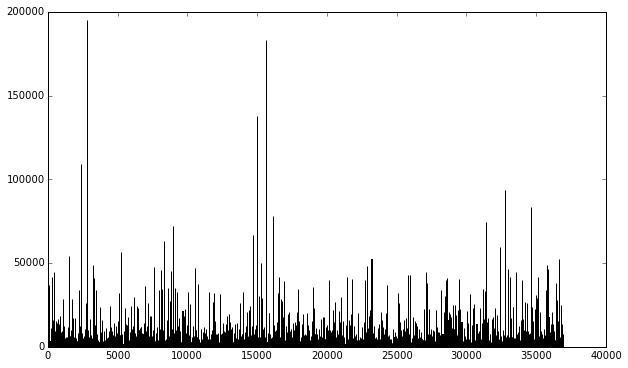

In [47]:
plt.bar(np.asarray(data.index),np.asarray(data["TOTAL OFFICE-BASED EXP 13"]))

The graph above is a line plot of billed charges vs index in the dataframe. It looks like the outliers are certainly anomalous, but not so much that I want to discard them. For reference, there are just as many data points in the 50k-100k range, and that seems plausible to me in light of the fact that the sickest patients cost disproportionately more to treat.

Let's look at the other explained variables:

In [38]:
data["TOTAL OUTPATIENT PROVIDER EXP 13"].describe()

count    36940.000000
mean        45.211722
std        385.887201
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      26703.000000
Name: TOTAL OUTPATIENT PROVIDER EXP 13, dtype: float64

There seems to be even more skew in outpatient expenses: more than 75% of people spend nothing, yet the maximum spent is over 25k.

Let's look at some plots:

<Container object of 36940 artists>

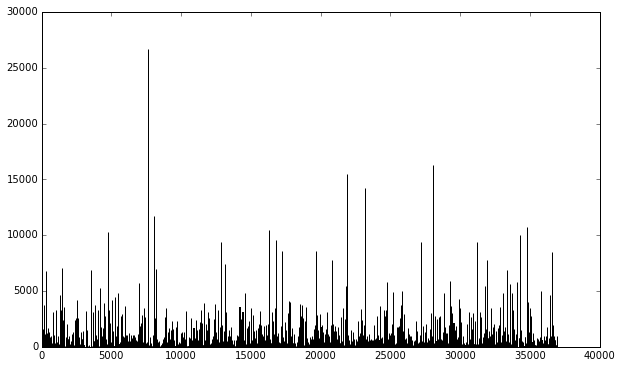

In [48]:
plt.bar(np.asarray(data.index),np.asarray(data["TOTAL OUTPATIENT PROVIDER EXP 13"]))

This isn't particularly helpful. Maybe it'd be better to look at records with positive expenses and examine those separately.

In [38]:
data["TOTAL OUTPATIENT PROVIDER EXP 13"][data["TOTAL OUTPATIENT PROVIDER EXP 13"]>0].describe()

count     2557.000000
mean       653.156433
std       1324.679341
min          1.000000
25%         75.000000
50%        222.000000
75%        706.000000
max      26703.000000
Name: TOTAL OUTPATIENT PROVIDER EXP 13, dtype: float64

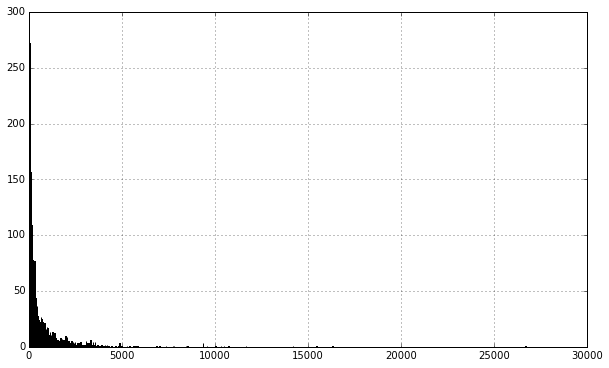

In [39]:
data["TOTAL OUTPATIENT PROVIDER EXP 13"][data["TOTAL OUTPATIENT PROVIDER EXP 13"]>0].hist(bins=1000)

That's more helpful. It also looks like there's little reason to discard the outliers - it looks like there's an understandable pattern at play here demonstrated by the visualization.

As an interesting visualization of how few people actually have expenses for outpatient services, let's run the same plot but without restricting to those that have positive expenses:

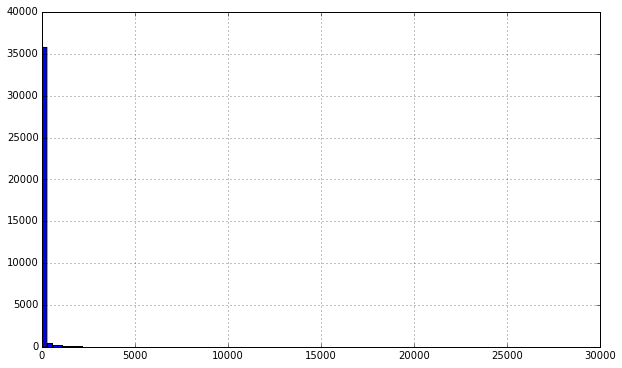

In [40]:
data["TOTAL OUTPATIENT PROVIDER EXP 13"].hist(bins=100)

The vast majority of people are at 0, and I can barely see the rest of the histogram.

This level of zero-clustering looks like it will be important to account for in the modeling process. Since positive expenses in this category are rare, the cost functions that we optimize to deduce the correct model parameters will be very strongly influenced by the fact that most of the data points lie at 0. It may be necessary to upsample in some way, or equivalently penalize the data points at 0 in order to generate a helpful model, and the penalization will probably be subject to tuning at the end of all of this.

The last two response variables are for inpatient expenses and ER expenses:


In [41]:
data["TOT HOSP IP FACILITY + DR EXP 13"].describe()

count     36940.000000
mean        977.643097
std        7413.503502
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      320929.000000
Name: TOT HOSP IP FACILITY + DR EXP 13, dtype: float64

In [42]:
data["TOTAL ER FACILITY + DR EXP 13"].describe()

count    36940.000000
mean       176.546833
std       1029.557499
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      63179.000000
Name: TOTAL ER FACILITY + DR EXP 13, dtype: float64

Similar skew for both.

In [43]:
data["TOT HOSP IP FACILITY + DR EXP 13"][data["TOT HOSP IP FACILITY + DR EXP 13"]>0].describe()

count      2220.000000
mean      16267.628829
std       25808.111520
min           3.000000
25%        4225.750000
50%        8584.500000
75%       17470.250000
max      320929.000000
Name: TOT HOSP IP FACILITY + DR EXP 13, dtype: float64

In [44]:
data["TOTAL ER FACILITY + DR EXP 13"][data["TOTAL ER FACILITY + DR EXP 13"]>0].describe()

count     4922.000000
mean      1324.997968
std       2536.670125
min          3.000000
25%        248.000000
50%        590.500000
75%       1363.750000
max      63179.000000
Name: TOTAL ER FACILITY + DR EXP 13, dtype: float64

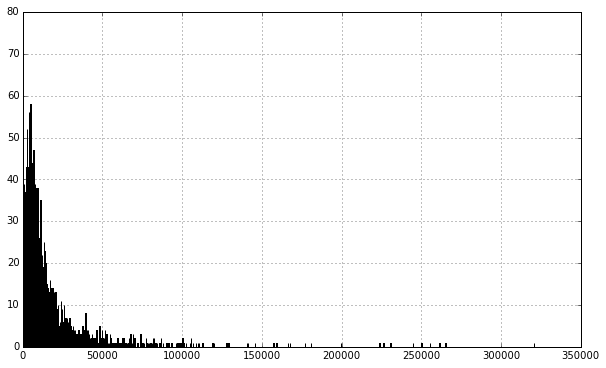

In [45]:
data["TOT HOSP IP FACILITY + DR EXP 13"][data["TOT HOSP IP FACILITY + DR EXP 13"]>0].hist(bins=1000)

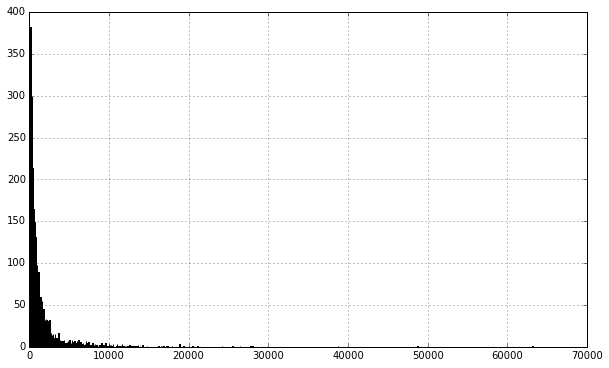

In [46]:
data["TOTAL ER FACILITY + DR EXP 13"][data["TOTAL ER FACILITY + DR EXP 13"]>0].hist(bins=1000)

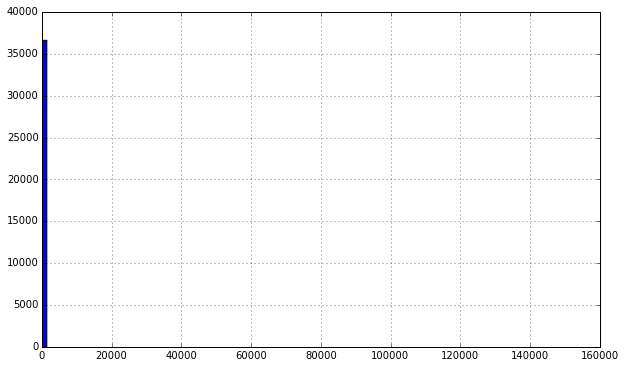

In [47]:
data["TOT HOSP IP FACILITY + DR EXP 13"][data["TOT HOSP IP FACILITY + DR EXP 13"]].hist(bins=100)

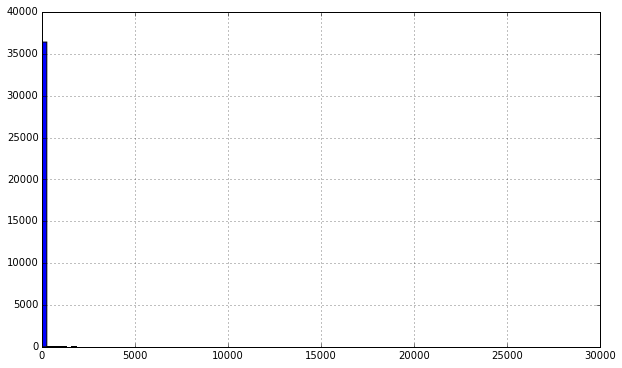

In [48]:
data["TOTAL ER FACILITY + DR EXP 13"][data["TOTAL ER FACILITY + DR EXP 13"]].hist(bins=100)

Once again, the skew (or zero clustering) for these categories is very pronounced.

Now that we've looked at plots for the response variables, let's take a look at the distributions for the explanatory variables.

There are a lot of these, so I'll devote a blog post to looking at these separately and in a systematic way.

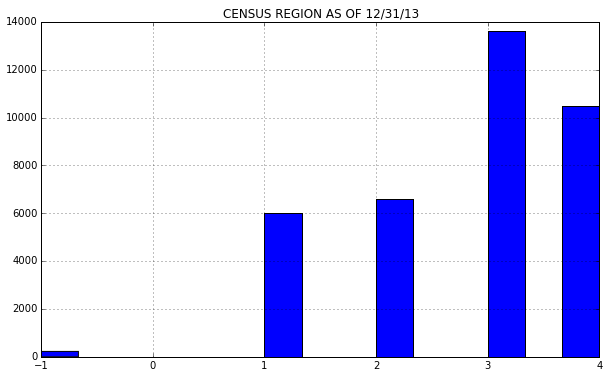

In [49]:
term=data.columns[-2]
numbins=len(data[term].value_counts())
data[term].hist(bins=numbins+10)
plt.title(term)
    

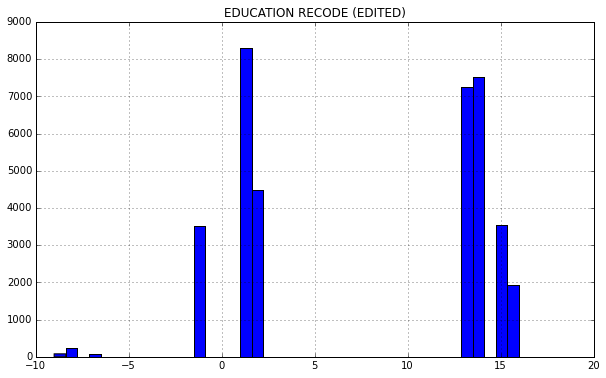

In [50]:
term=data.columns[-1]
numbins=len(data[term].value_counts())
data[term].hist(bins=numbins+30)
plt.title(term)
    

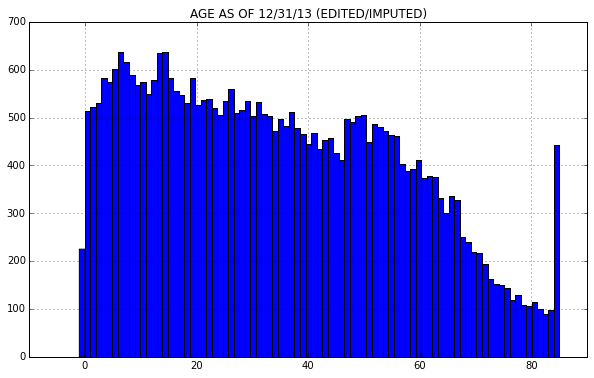

In [51]:
term=data.columns[0]
numbins=len(data[term].value_counts())
data[term].hist(bins=numbins)
plt.title(term)
    

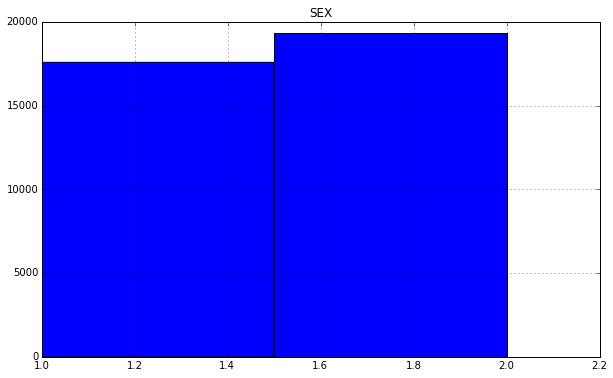

In [52]:
term=data.columns[1]
numbins=len(data[term].value_counts())
data[term].hist(bins=numbins)
plt.title(term)
    

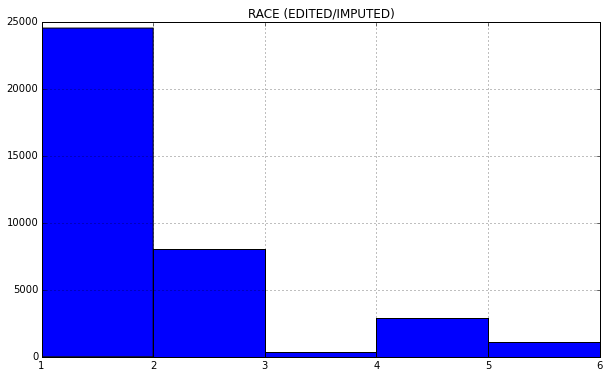

In [53]:
term=data.columns[2]
numbins=len(data[term].value_counts())
data[term].hist(bins=numbins)
plt.title(term)


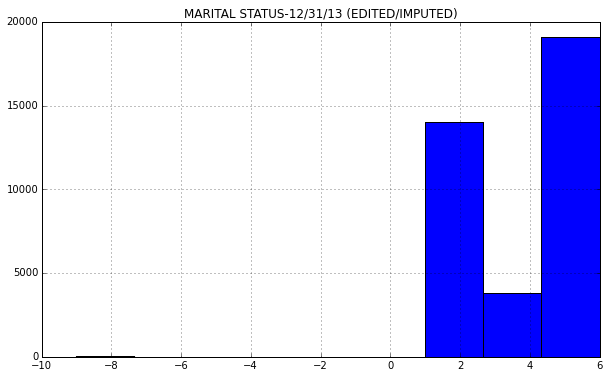

In [54]:
term=data.columns[3]
numbins=len(data[term].value_counts())
data[term].hist(bins=numbins)
plt.title(term)
    

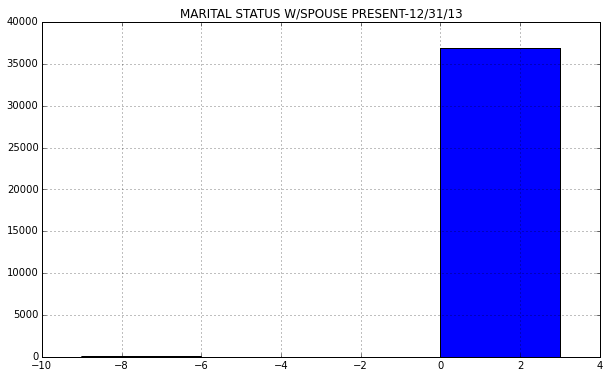

In [55]:
term=data.columns[4]
numbins=len(data[term].value_counts())
data[term].hist(bins=numbins)
plt.title(term)
    

YEAR OF EDUCATION OR HIGHEST DEGREE


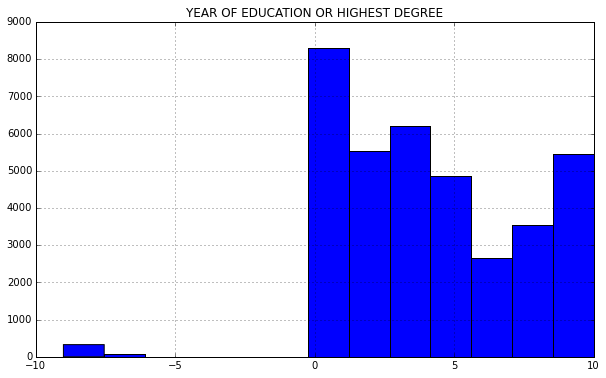

In [56]:
term=data.columns[5]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins)
else:
    data[term].plot()
plt.title(term)
    

FAMILY'S TOTAL INCOME


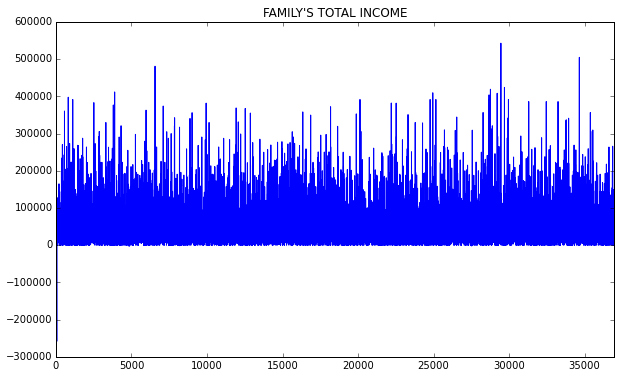

In [57]:
term=data.columns[6]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins)
else:
    data[term].plot()
plt.title(term)

HIGH BLOOD PRESSURE DIAG (>17)


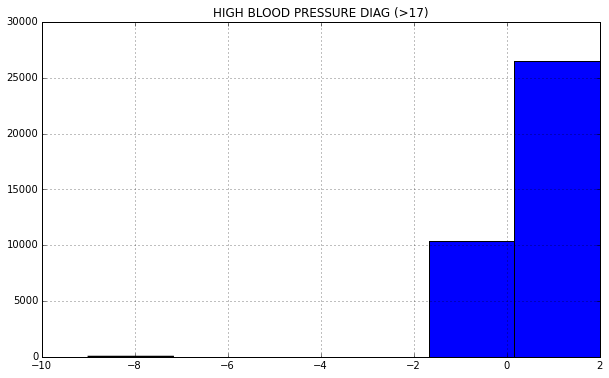

In [58]:
term=data.columns[7]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins)
else:
    data[term].plot()
plt.title(term)
    

CORONARY HRT DISEASE DIAG (>17)


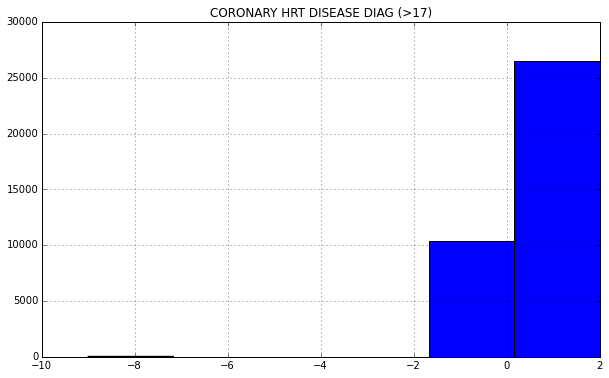

In [59]:
term=data.columns[8]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins)
else:
    data[term].plot()
plt.title(term)

AGE OF DIAGNOSIS-HIGH BLOOD PRESSURE


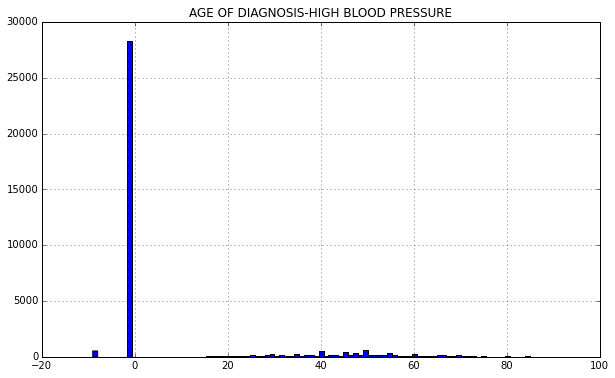

In [60]:
term=data.columns[9]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins)
else:
    data[term].plot()
plt.title(term)

ANGINA DIAGNOSIS (>17)


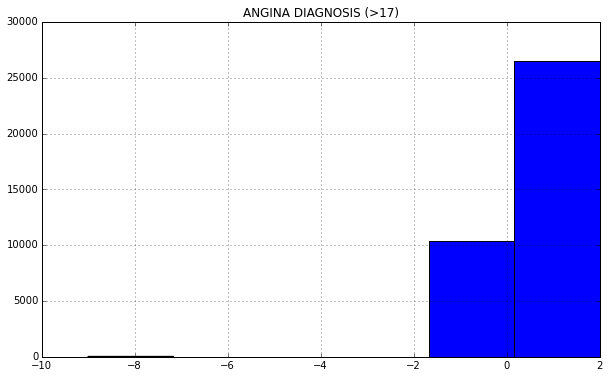

In [61]:
term=data.columns[12]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins)
else:
    data[term].plot()
plt.title(term)

AGE OF DIAGNOSIS-ANGINA


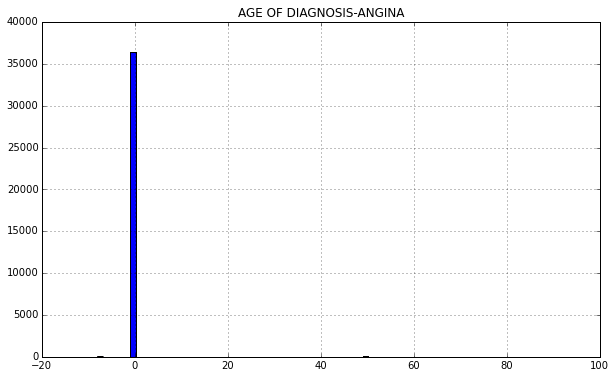

In [62]:
term=data.columns[13]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins)
else:
    data[term].plot()
plt.title(term)

HEART ATTACK (MI) DIAG (>17)


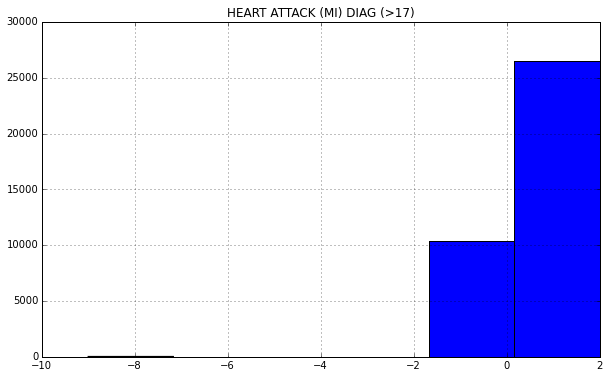

In [63]:
term=data.columns[14]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins)
else:
    data[term].plot()
plt.title(term)

AGE OF DIAGNOSIS-HEART ATTACK(MI)


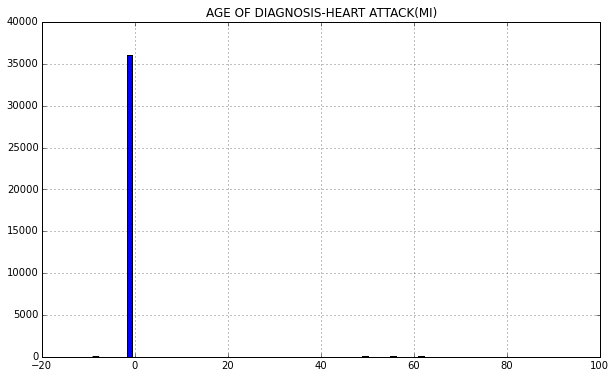

In [64]:
term=data.columns[15]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins)
else:
    data[term].plot()
plt.title(term)
    

OTHER HEART DISEASE DIAG (>17)


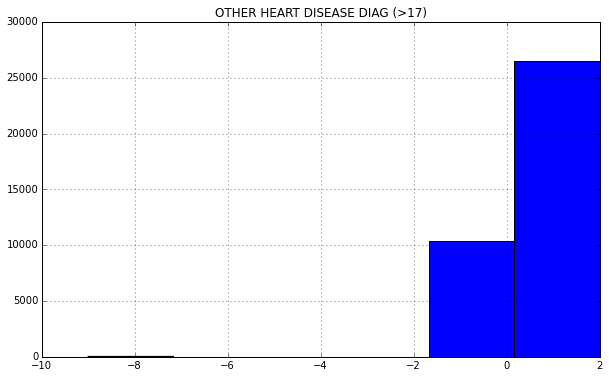

In [65]:
term=data.columns[16]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins)
else:
    data[term].plot()
plt.title(term)

AGE OF DIAGNOSIS-OTHER HEART DISEASE


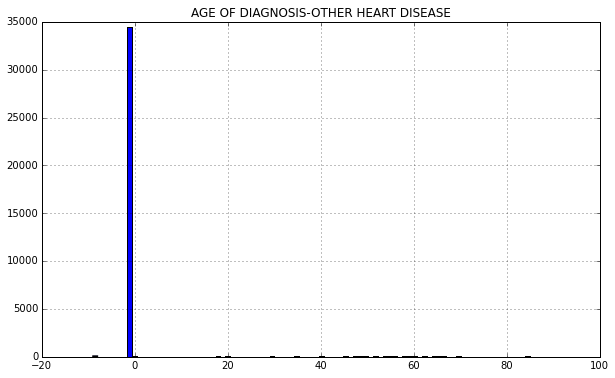

In [66]:
term=data.columns[17]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins)
else:
    data[term].plot()
plt.title(term)

STROKE DIAGNOSIS (>17)


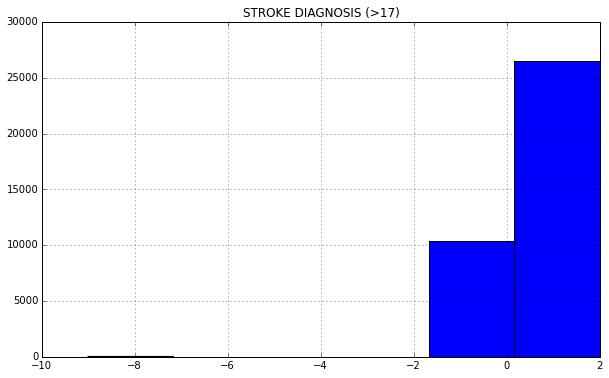

In [67]:
term=data.columns[18]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins)
else:
    data[term].plot()
plt.title(term)

AGE OF DIAGNOSIS-STROKE


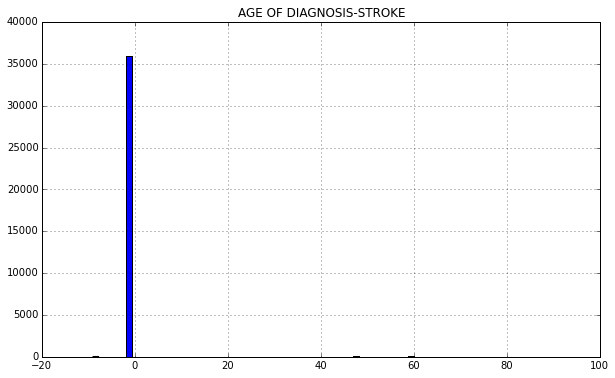

In [68]:
term=data.columns[19]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins)
else:
    data[term].plot()
plt.title(term)

EMPHYSEMA DIAGNOSIS (>17)


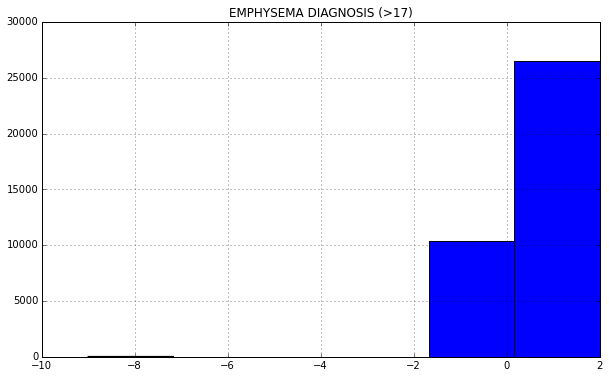

In [69]:
term=data.columns[20]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins)
else:
    data[term].plot()
plt.title(term)

AGE OF DIAGNOSIS-EMPHYSEMA


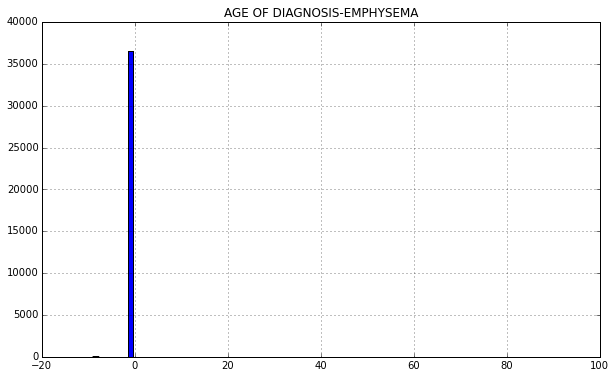

In [70]:
term=data.columns[21]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins)
else:
    data[term].plot()
plt.title(term)

CHRONC BRONCHITS LAST 12 MTHS (>17)-R3/1


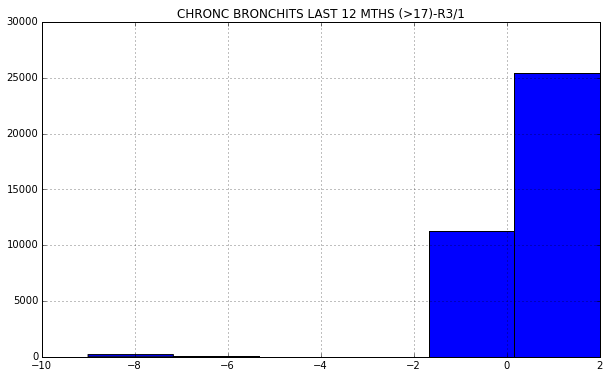

In [71]:
term=data.columns[22]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins)
else:
    data[term].plot()
plt.title(term)
    

CHRONC BRONCHITS LAST 12 MTHS (>17)-R5/3


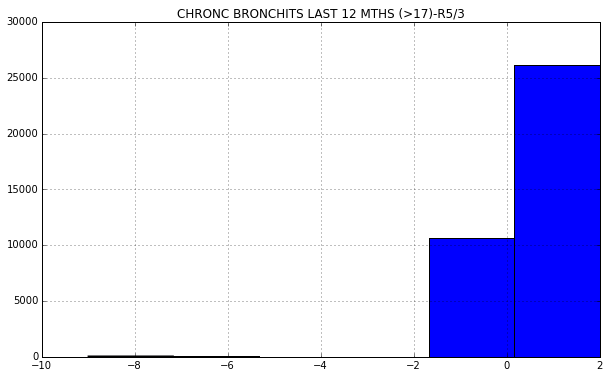

In [72]:
term=data.columns[23]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins)
else:
    data[term].plot()
plt.title(term)
    

HIGH CHOLESTEROL DIAGNOSIS (>17)


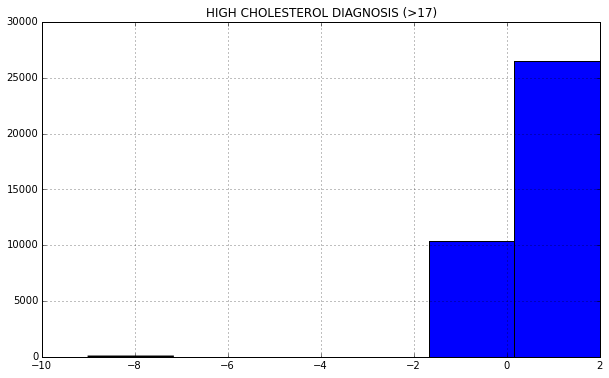

In [73]:
term=data.columns[24]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins)
else:
    data[term].plot()
plt.title(term)
    

HIGH CHOLESTEROL DIAGNOSIS (>17)


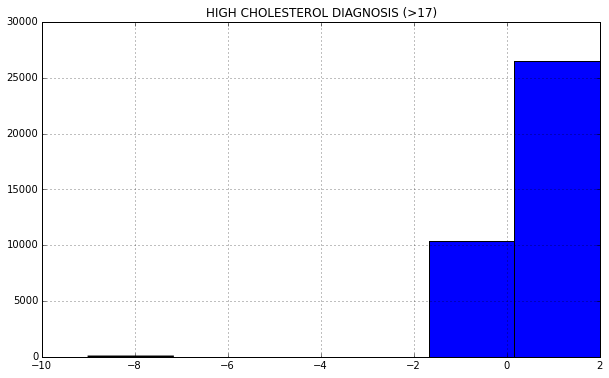

In [74]:
term=data.columns[24]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins)
else:
    data[term].plot()
plt.title(term)
    

HIGH CHOLESTEROL DIAGNOSIS (>17)


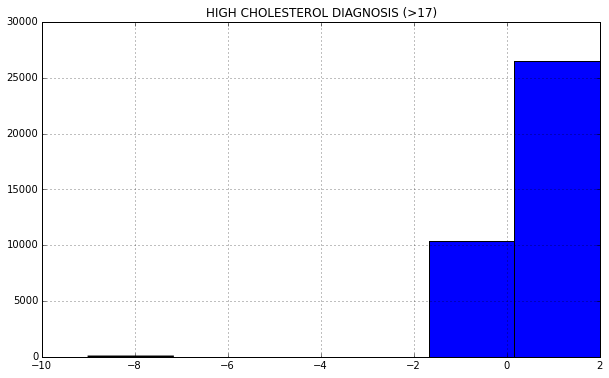

In [75]:
term=data.columns[24]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins)
else:
    data[term].plot()
plt.title(term)
    

AGE OF DIAGNOSIS-HIGH CHOLESTEROL


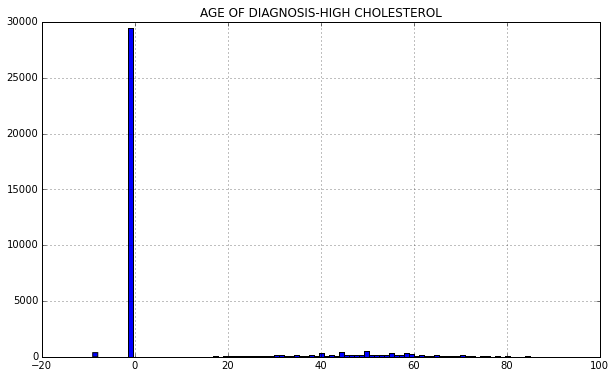

In [76]:
term=data.columns[25]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins)
else:
    data[term].plot()
plt.title(term)
    

CANCER DIAGNOSIS (>17)


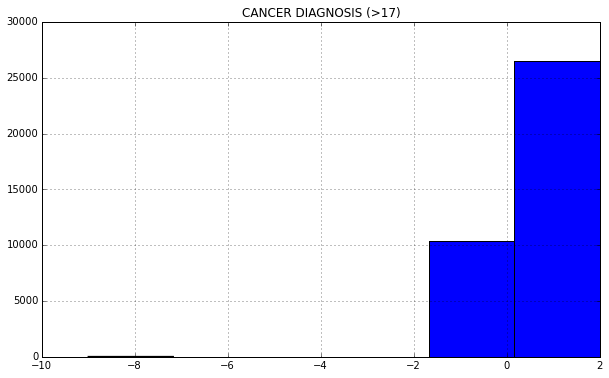

In [77]:
term=data.columns[26]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins)
else:
    data[term].plot()
plt.title(term)
    

CANCER DIAGNOSED - BLADDER (>17)


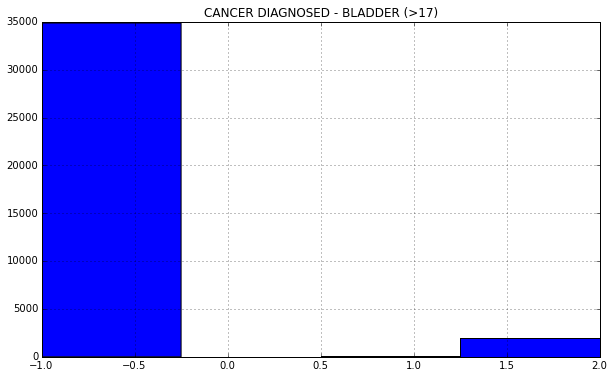

In [78]:
term=data.columns[27]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+1)
else:
    data[term].plot()
plt.title(term)
    

CANCER DIAGNOSED - BREAST (>17)


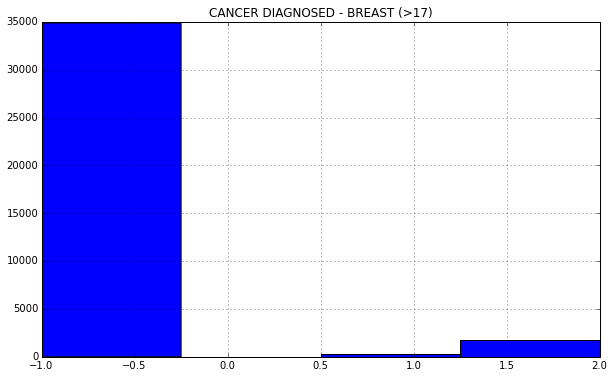

In [79]:
term=data.columns[28]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+1)
else:
    data[term].plot()
plt.title(term)
    

CANCER DIAGNOSED - CERVIX (>17)


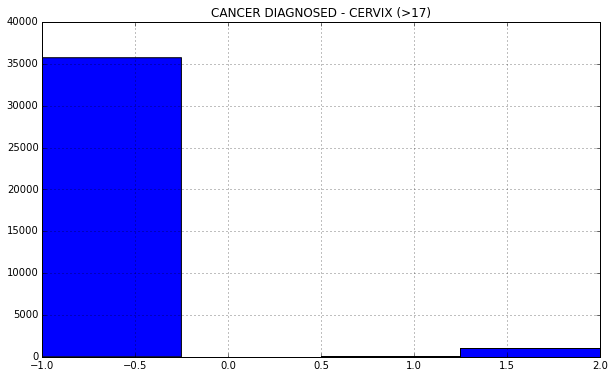

In [80]:
term=data.columns[29]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+1)
else:
    data[term].plot()
plt.title(term)
    

CANCER DIAGNOSED - COLON (>17)


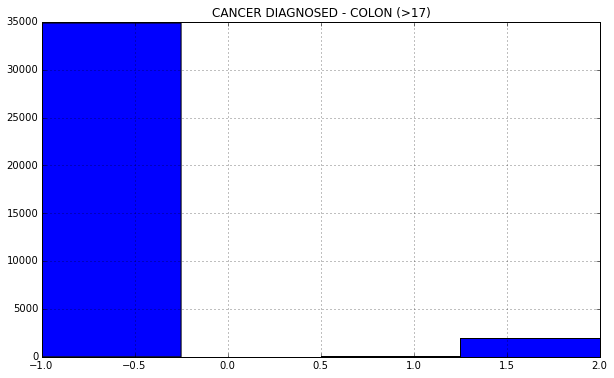

In [81]:
term=data.columns[30]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+1)
else:
    data[term].plot()
plt.title(term)
    

CANCER DIAGNOSED - LUNG (>17)


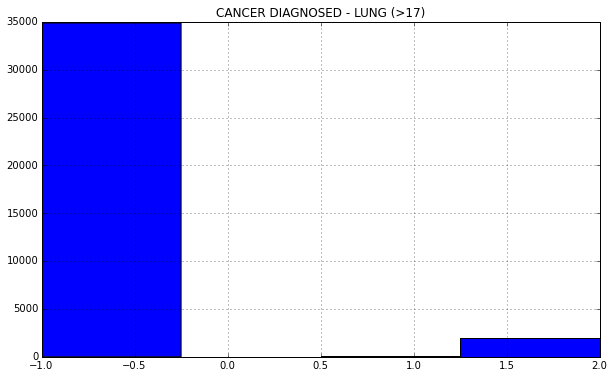

In [82]:
term=data.columns[31]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+1)
else:
    data[term].plot()
plt.title(term)
    

CANCER DIAGNOSED - LYMPHOMA (>17)


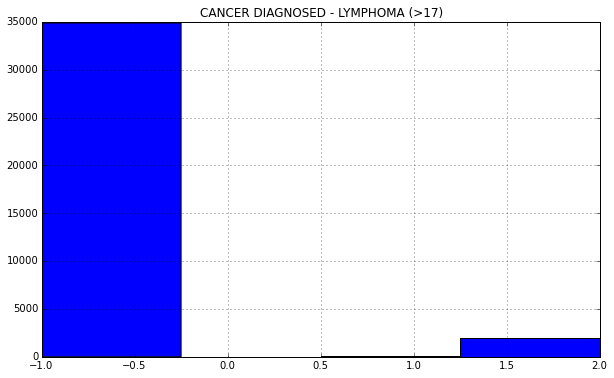

In [83]:
term=data.columns[32]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+1)
else:
    data[term].plot()
plt.title(term)
    

CANCER DIAGNOSED - MELANOMA (>17)


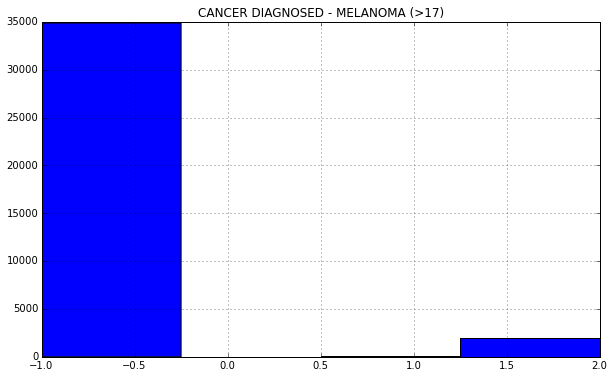

In [84]:
term=data.columns[33]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+1)
else:
    data[term].plot()
plt.title(term)
    

CANCER DIAGNOSED - OTHER (>17)


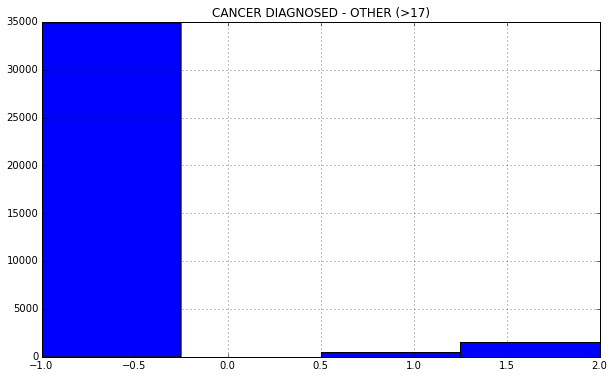

In [85]:
term=data.columns[34]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+1)
else:
    data[term].plot()
plt.title(term)
    

CANCER DIAGNOSED - PROSTATE (>17)


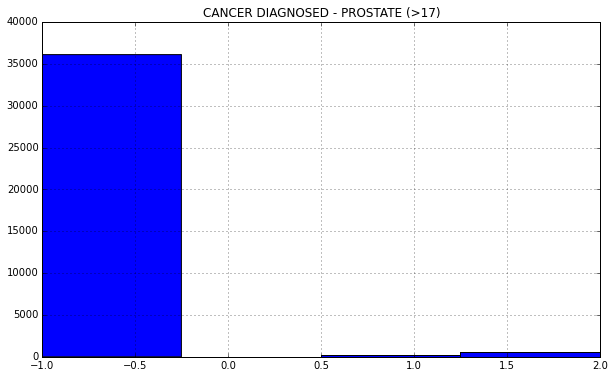

In [86]:
term=data.columns[35]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+1)
else:
    data[term].plot()
plt.title(term)
    

CANCER DIAGNOSED - SKIN-NONMELANO (>17)


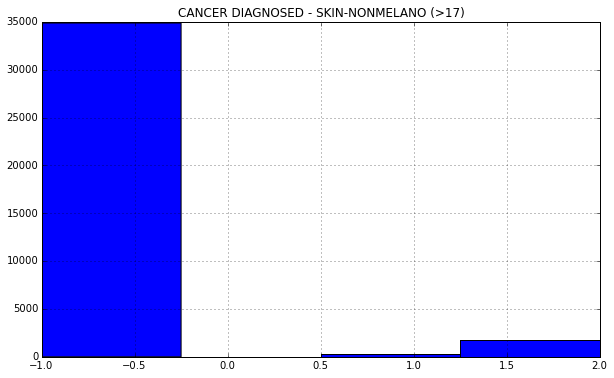

In [87]:
term=data.columns[36]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+1)
else:
    data[term].plot()
plt.title(term)
    

CANCER DIAGNOSED-SKIN-UNKNOWN TYPE (>17)


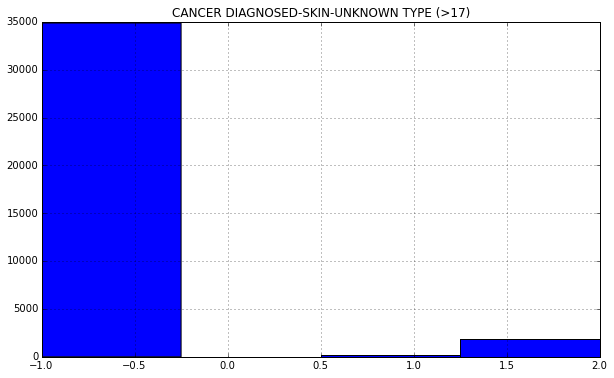

In [88]:
term=data.columns[37]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+1)
else:
    data[term].plot()
plt.title(term)
    

CANCER DIAGNOSED - UTERUS (>17)


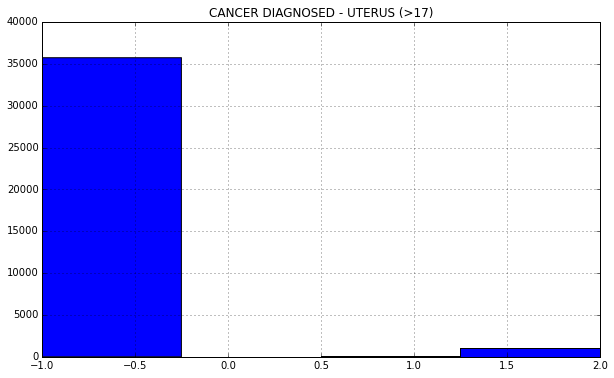

In [89]:
term=data.columns[38]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+1)
else:
    data[term].plot()
plt.title(term)
    

DIABETES DIAGNOSIS (>17)


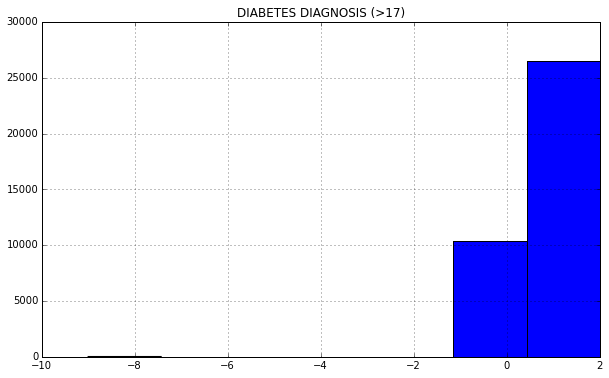

In [90]:
term=data.columns[39]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+1)
else:
    data[term].plot()
plt.title(term)
    

AGE OF DIAGNOSIS-DIABETES


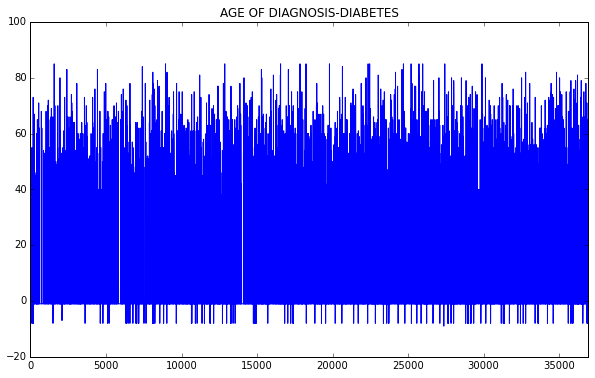

In [91]:
term=data.columns[40]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+1)
else:
    data[term].plot()
plt.title(term)
    

JOINT PAIN LAST 12 MONTHS (>17) - RD 3/1


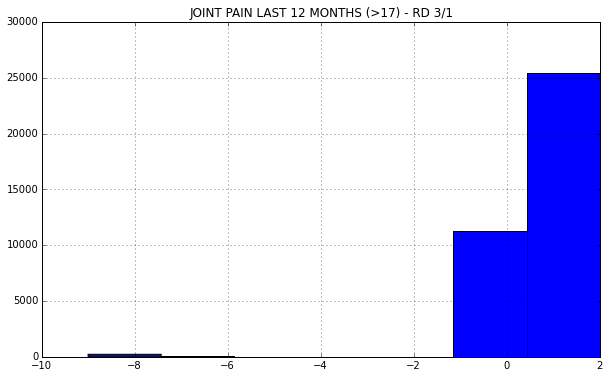

In [92]:
term=data.columns[41]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+1)
else:
    data[term].plot()
plt.title(term)
    

JOINT PAIN LAST 12 MONTHS (>17) - RD 5/3


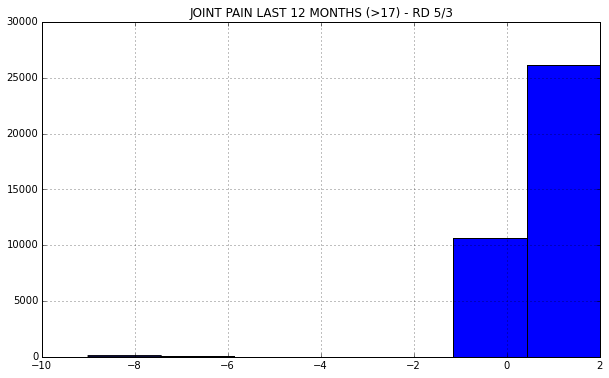

In [93]:
term=data.columns[42]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+1)
else:
    data[term].plot()
plt.title(term)
    

ARTHRITIS DIAGNOSIS (>17)


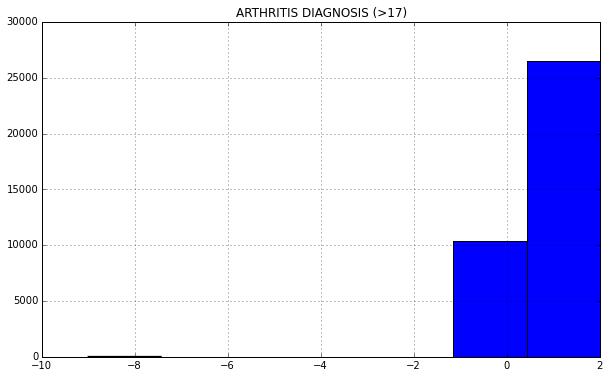

In [94]:
term=data.columns[43]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+1)
else:
    data[term].plot()
plt.title(term)
    

TYPE OF ARTHRITIS DIAGNOSED (>17)


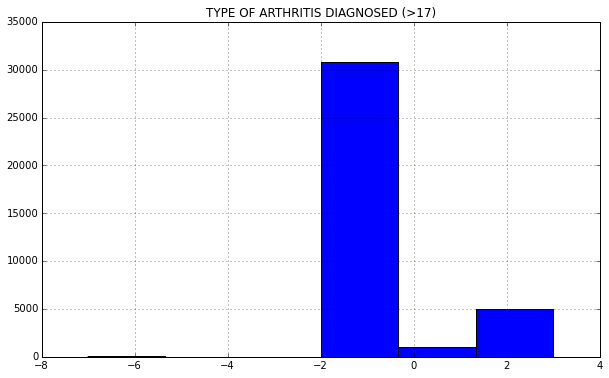

In [95]:
term=data.columns[44]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+1)
else:
    data[term].plot()
plt.title(term)
    

AGE OF DIAGNOSIS-ARTHRITIS


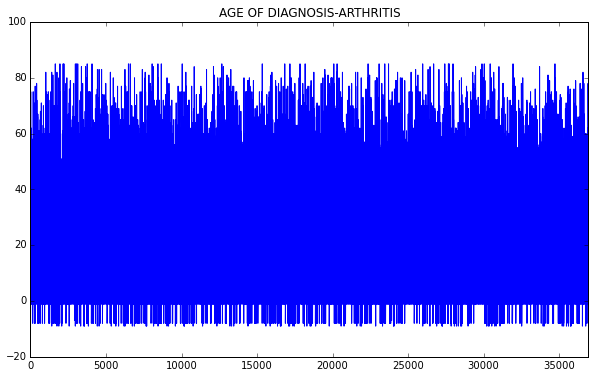

In [96]:
term=data.columns[45]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+1)
else:
    data[term].plot()
plt.title(term)
    

ASTHMA DIAGNOSIS


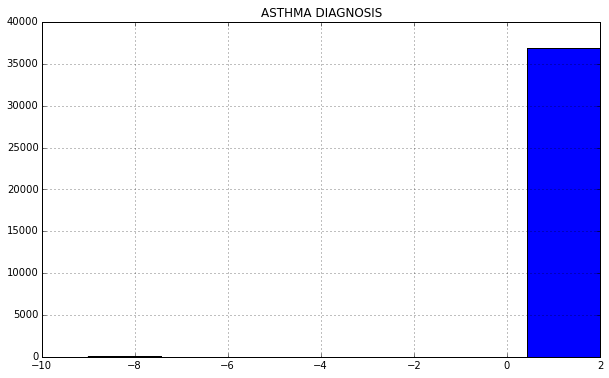

In [97]:
term=data.columns[46]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+1)
else:
    data[term].plot()
plt.title(term)
    

AGE OF DIAGNOSIS-ASTHMA


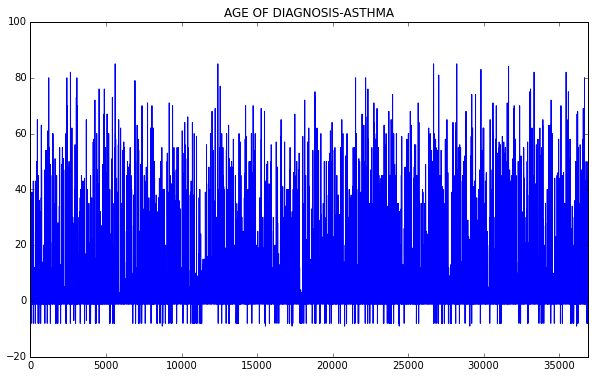

In [98]:
term=data.columns[47]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

DOES PERSON STILL HAVE ASTHMA-RD3/1


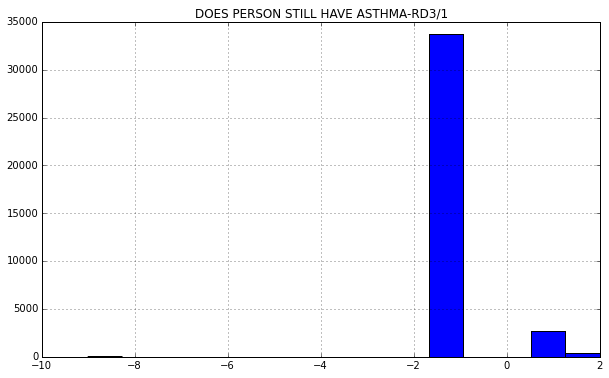

In [99]:
term=data.columns[48]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

DOES PERSON STILL HAVE ASTHMA - RD 5/3


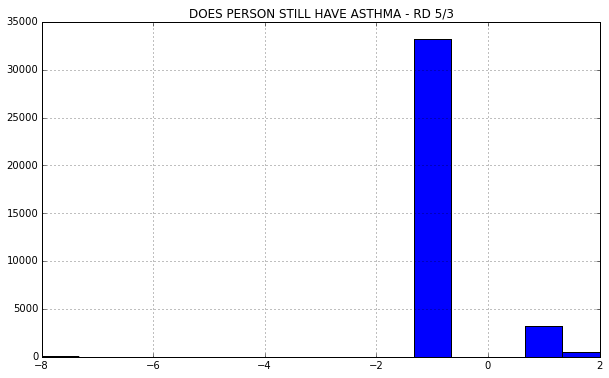

In [100]:
term=data.columns[49]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

ASTHMA ATTACK LAST 12 MOS - RD3/1


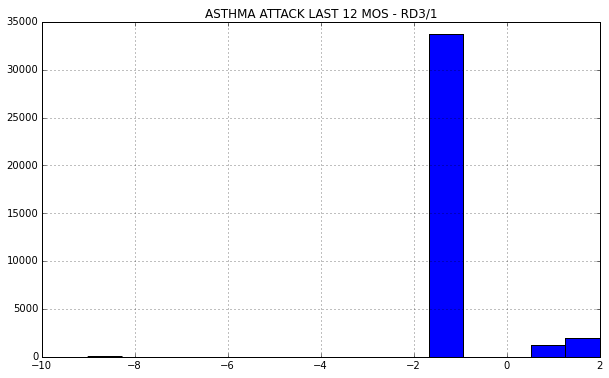

In [101]:
term=data.columns[50]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

WHEN WAS LAST EPISODE OF ASTHMA - RD 3/1


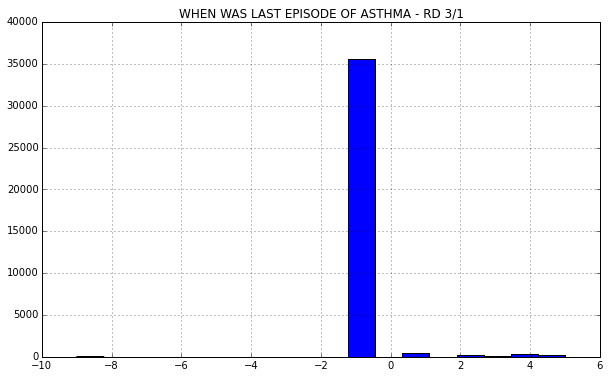

In [102]:
term=data.columns[51]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

WHEN WAS LAST EPISODE OF ASTHMA - RD 5/3


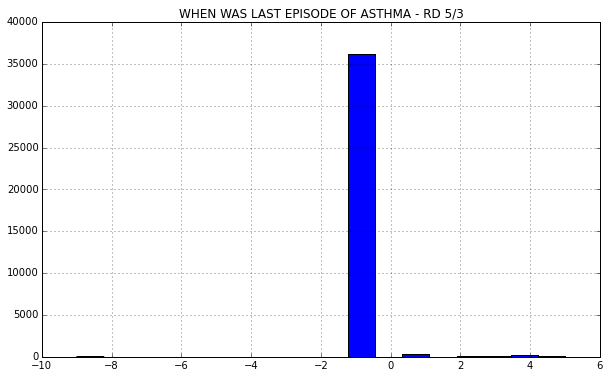

In [103]:
term=data.columns[52]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

USED ACUTE PRES INHALER LAST 3 MOS-RD5/3


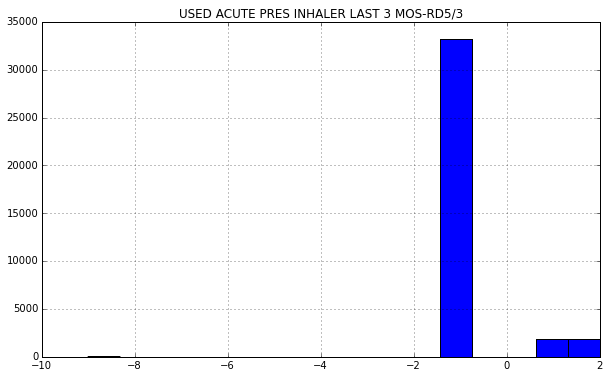

In [104]:
term=data.columns[53]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

USED>3ACUTE CN PRES INH LAST 3 MOS-RD5/3


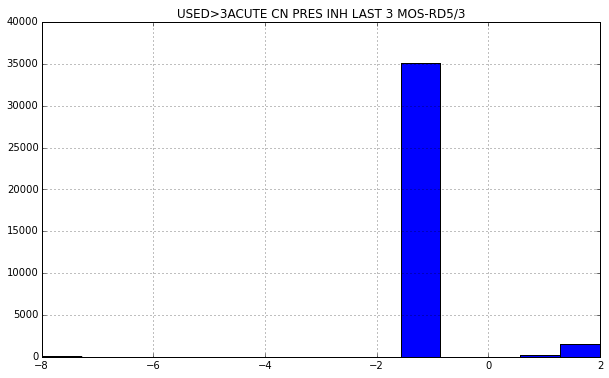

In [105]:
term=data.columns[54]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

EVER USED PREV DAILY ASTHMA MEDS -RD 5/3


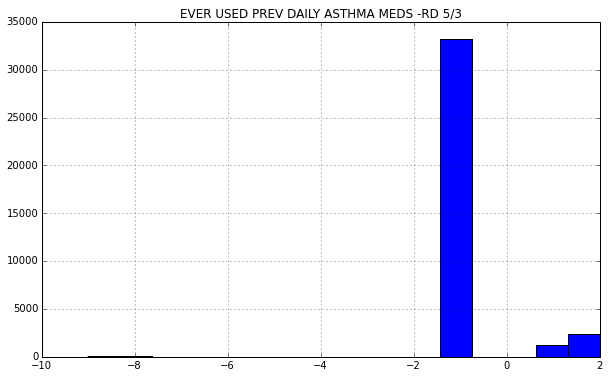

In [106]:
term=data.columns[55]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

NOW TAKE PREV DAILY ASTHMA MEDS - RD 5/3


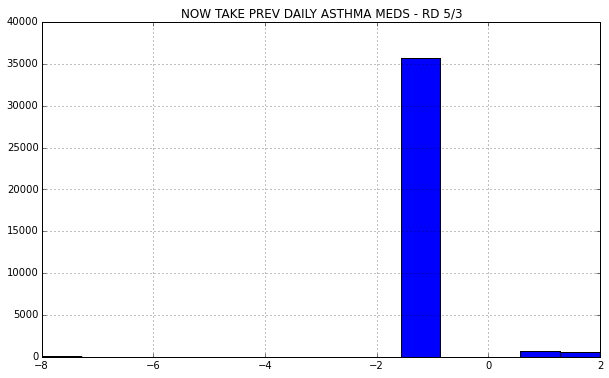

In [107]:
term=data.columns[56]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

HAVE PEAK FLOW METER AT HOME - RD 5/3


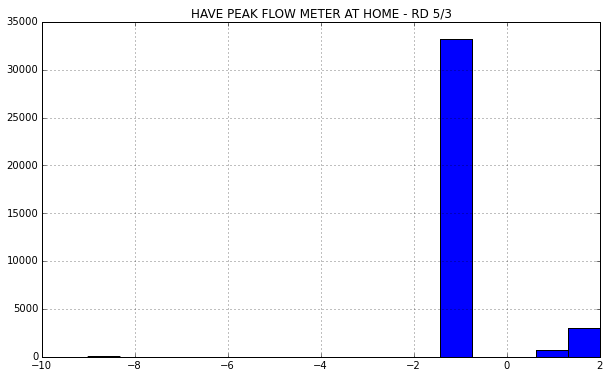

In [108]:
term=data.columns[57]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

EVER USED PEAK FLOW METER - RD 5/3


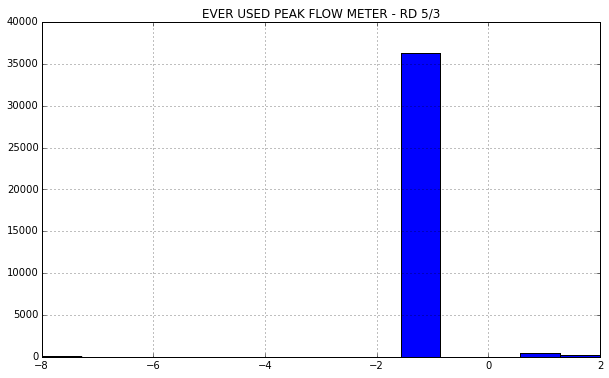

In [109]:
term=data.columns[58]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

WHEN LAST USED PEAK FLOW METER - RD 5/3


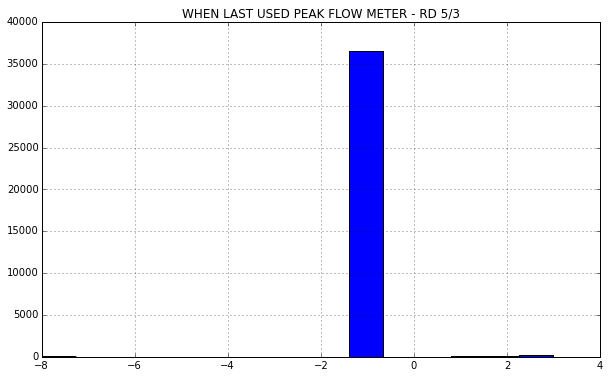

In [110]:
term=data.columns[59]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

ADHDADD DIAGNOSIS (5-17)


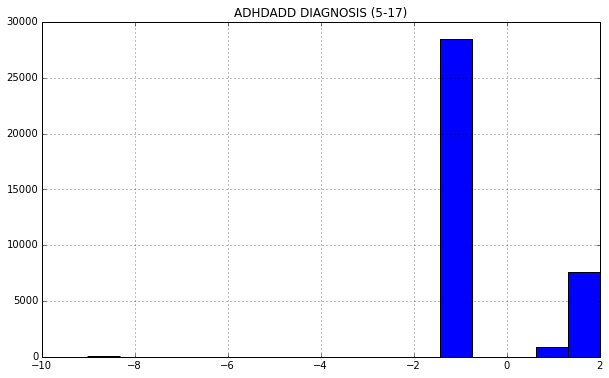

In [111]:
term=data.columns[60]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

AGE OF DIAGNOSIS-ADHD/ADD


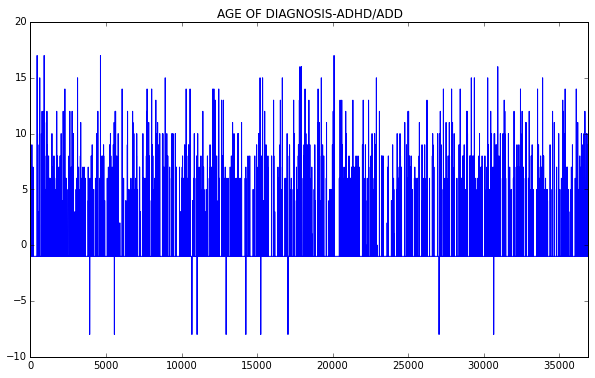

In [112]:
term=data.columns[61]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

PREGNANT DURING REF PERIOD - RD 3/1


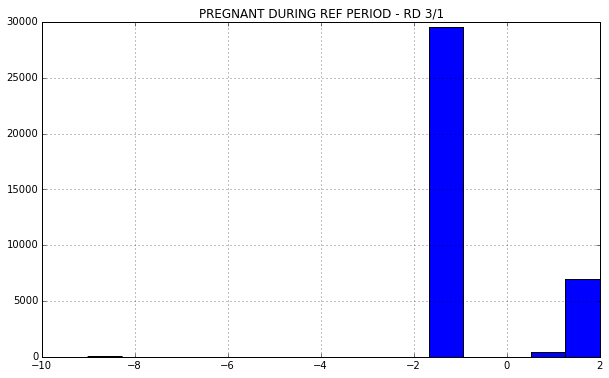

In [113]:
term=data.columns[62]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

LIMITATION IN PHYSICAL FUNCTIONING-RD3/1


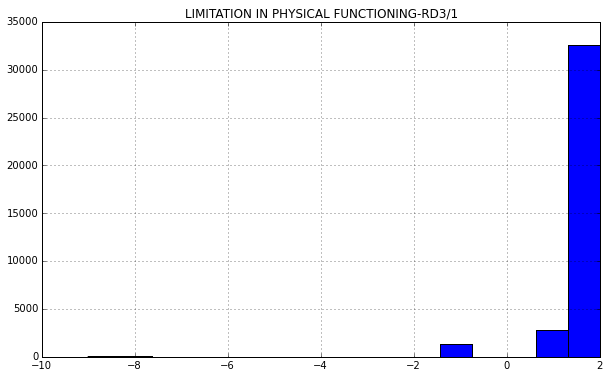

In [114]:
term=data.columns[63]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

EMPLOYMENT STATUS RD 3/1


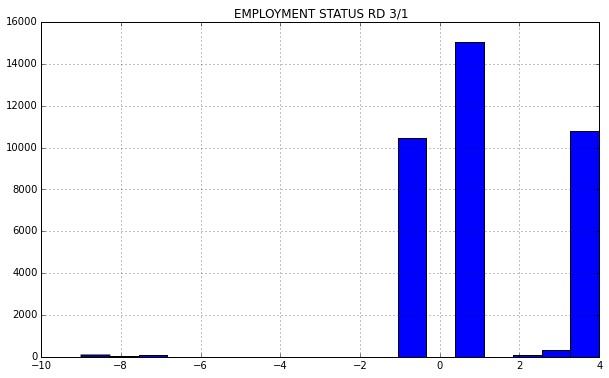

In [115]:
term=data.columns[64]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

HAS MORE THAN ONE JOB RD 3/1 INT DATE


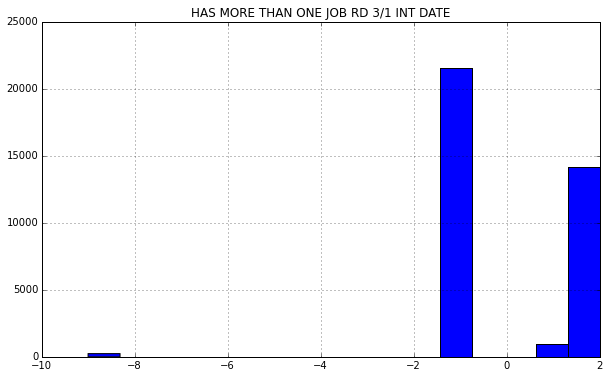

In [116]:
term=data.columns[65]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

SELF-EMPLOYED AT RD 3/1 CMJ


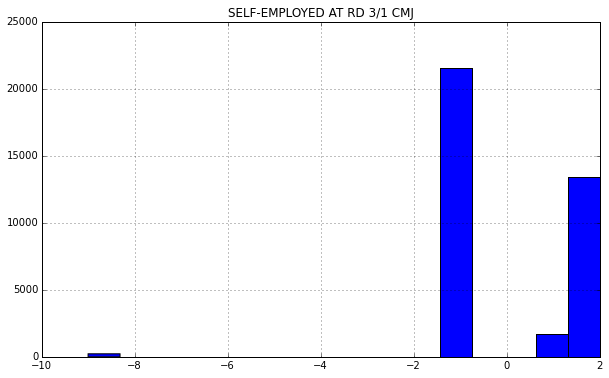

In [117]:
term=data.columns[66]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

CHOICE OF HEALTH PLANS AT RD 3/1 CMJ


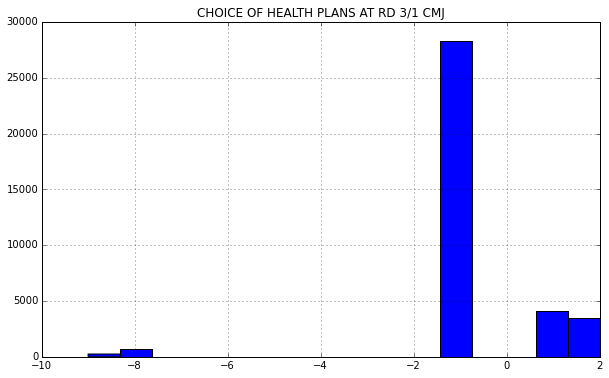

In [118]:
term=data.columns[67]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

INDUSTRY GROUP RD 3/1 CMJ


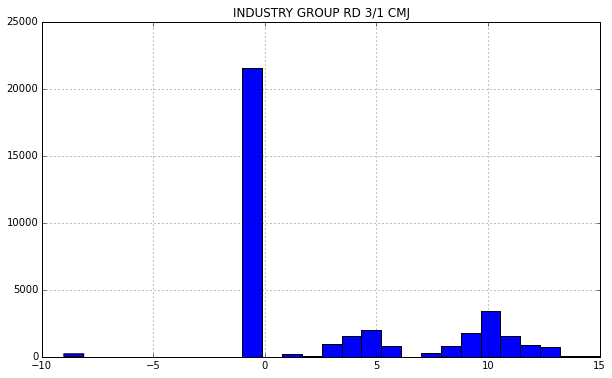

In [119]:
term=data.columns[68]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

UNION STATUS AT RD 3/1 CMJ


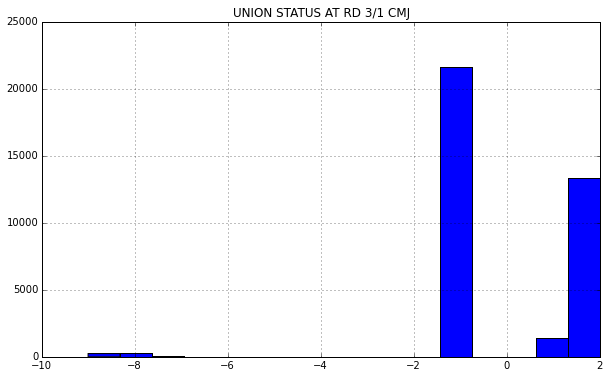

In [120]:
term=data.columns[69]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

OCCUPATION GROUP RD 3/1 CMJ


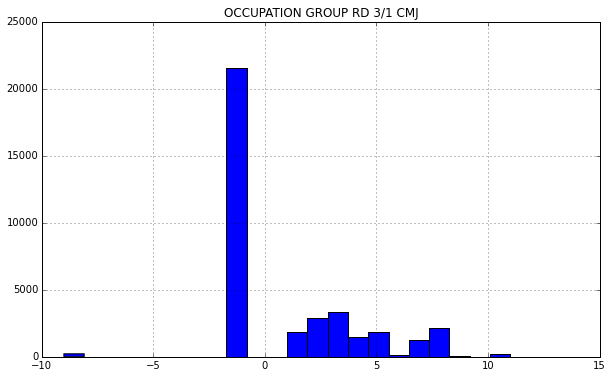

In [121]:
term=data.columns[70]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

HEALTH INSUR HELD FROM RD 3/1 CMJ (ED)


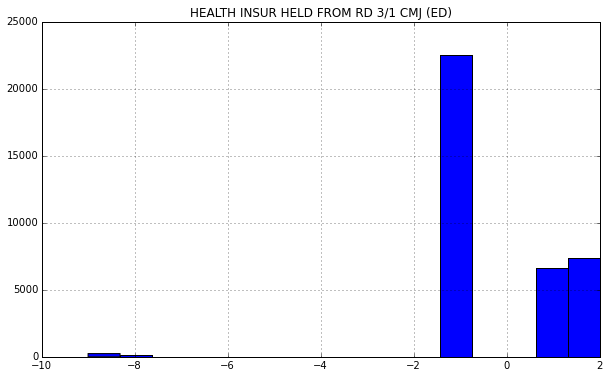

In [122]:
term=data.columns[71]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

HEALTH INSUR OFFERED BY RD 3/1 CMJ (ED)


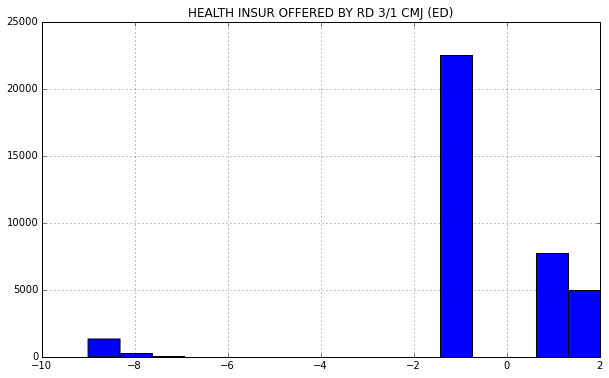

In [123]:
term=data.columns[72]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

EMPLOYER OFFERS HEALTH INS RD 3/1 CMJ


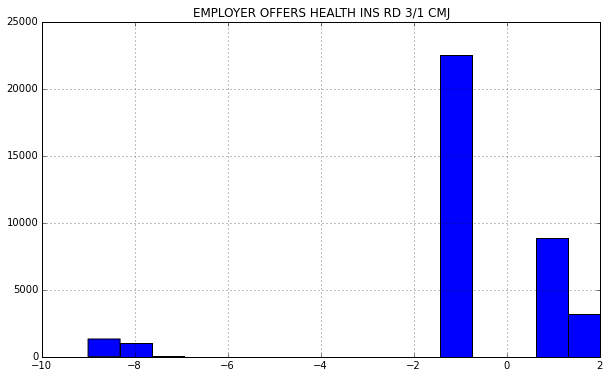

In [124]:
term=data.columns[73]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

FULL YEAR INSURANCE COVERAGE STATUS 2013


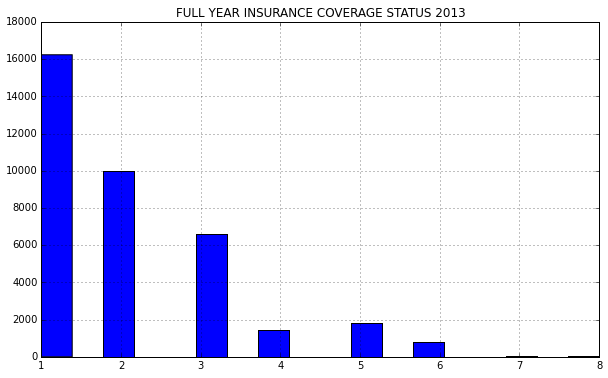

In [125]:
term=data.columns[74]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

ANYONE IN RU HAVE FSA - R3/1


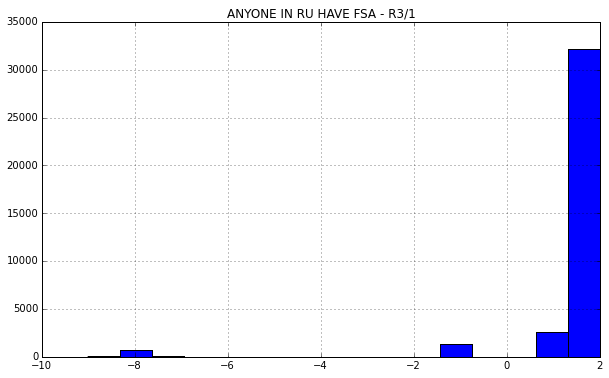

In [126]:
term=data.columns[75]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

# WKS/MON WOUT HLTH INS PRV YR-PN 18 ONL


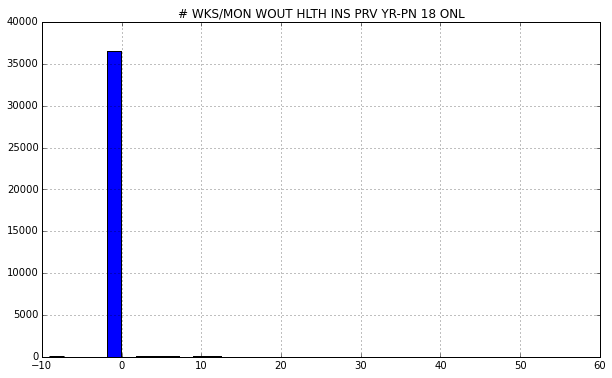

In [127]:
term=data.columns[76]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

PRIVATE INSURANCE ANY TIME IN R5/R3


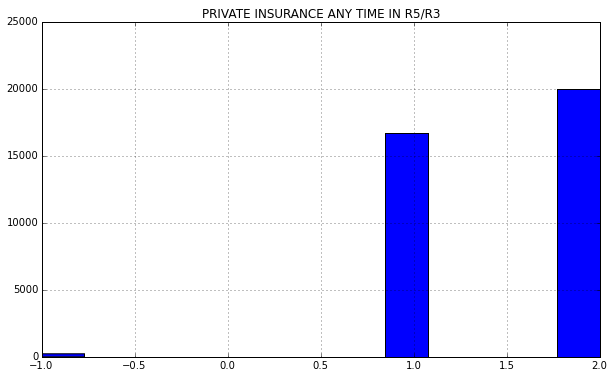

In [128]:
term=data.columns[77]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

PUBLIC INS ANY TIME IN R5/R3


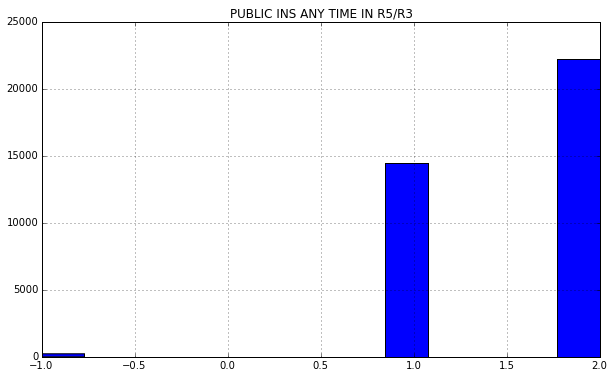

In [129]:
term=data.columns[78]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

INSURED ANY TIME IN R3/1


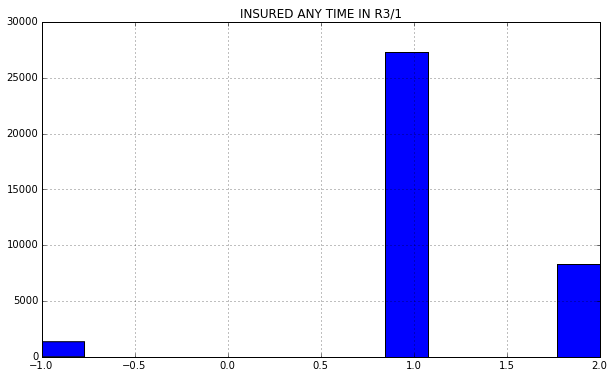

In [130]:
term=data.columns[79]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

ANY TIME COVERAGE BY STATE INS - R3/1


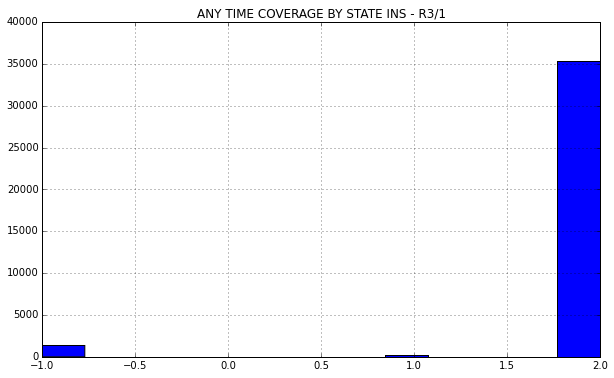

In [131]:
term=data.columns[80]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

# OFFICE-BASED PROVIDER VISITS 13


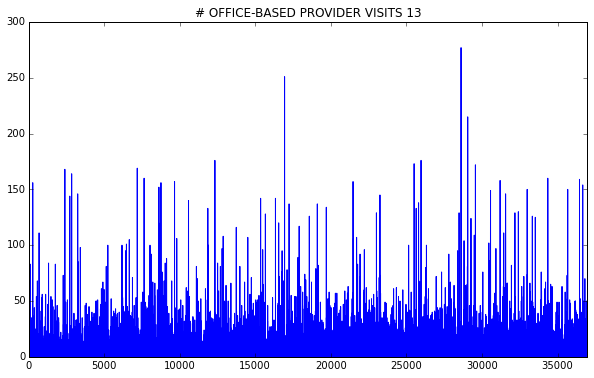

In [132]:
term=data.columns[81]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

# OUTPATIENT DEPT PROVIDER VISITS 13


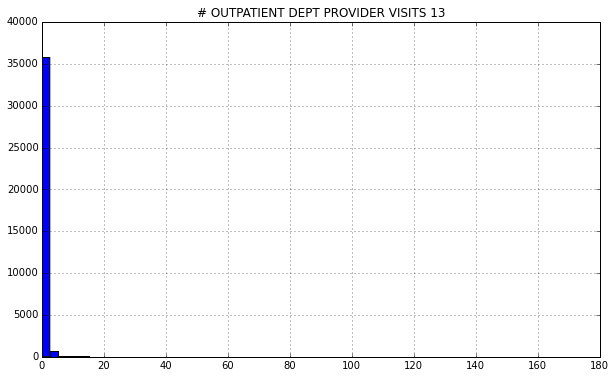

In [133]:
term=data.columns[82]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<100:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

# EMERGENCY ROOM VISITS 13


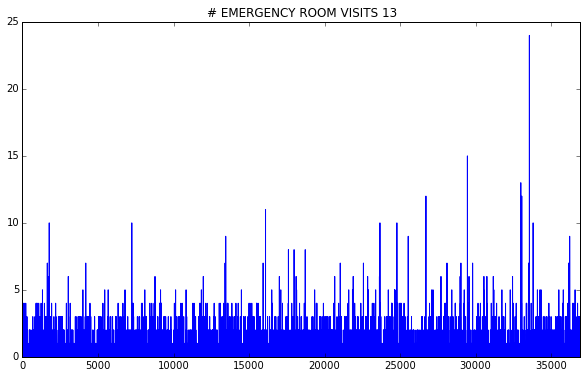

In [134]:
term=data.columns[83]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

# NIGHTS IN HOSP FOR DISCHARGES 2013


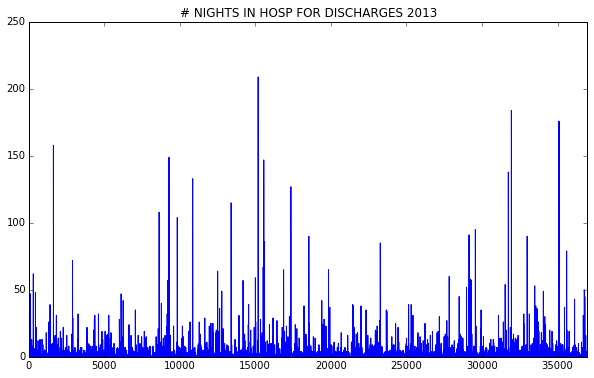

In [135]:
term=data.columns[84]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

FINAL PERSON WEIGHT 2013


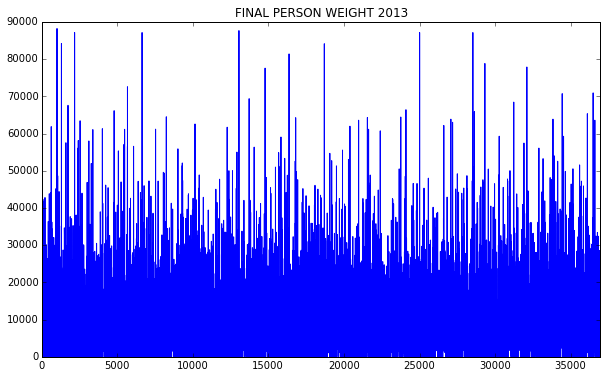

In [136]:
term=data.columns[85]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

TOTAL OFFICE-BASED EXP 13


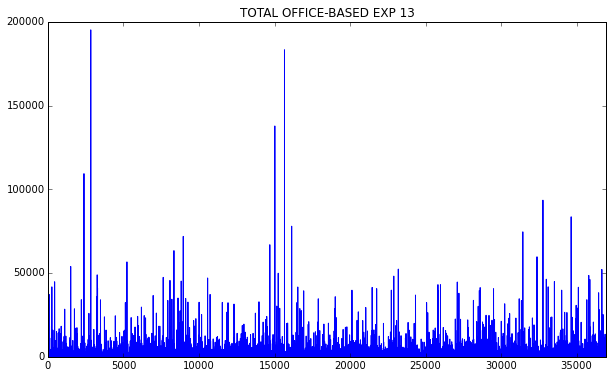

In [137]:
term=data.columns[86]
#print(data[term])
print(term)
#kind=input()
if len(data[term].value_counts())<10:
    numbins=len(data[term].value_counts())
    data[term].hist(bins=numbins+10)
else:
    data[term].plot()
plt.title(term)
    

That was a lot of looking. For the most part, eyeballing these plots doesn't turn up anything that I'd flag as problematic or bad data.



In [138]:
data.corr()

,AGE AS OF 12/31/13 (EDITED/IMPUTED),SEX,RACE (EDITED/IMPUTED),MARITAL STATUS-12/31/13 (EDITED/IMPUTED),MARITAL STATUS W/SPOUSE PRESENT-12/31/13,YEAR OF EDUCATION OR HIGHEST DEGREE,FAMILY'S TOTAL INCOME,HIGH BLOOD PRESSURE DIAG (>17),CORONARY HRT DISEASE DIAG (>17),AGE OF DIAGNOSIS-HIGH BLOOD PRESSURE,...,# OUTPATIENT DEPT PROVIDER VISITS 13,# EMERGENCY ROOM VISITS 13,# NIGHTS IN HOSP FOR DISCHARGES 2013,FINAL PERSON WEIGHT 2013,TOTAL OFFICE-BASED EXP 13,TOTAL OUTPATIENT PROVIDER EXP 13,TOT HOSP IP FACILITY + DR EXP 13,TOTAL ER FACILITY + DR EXP 13,CENSUS REGION AS OF 12/31/13,EDUCATION RECODE (EDITED)
AGE AS OF 12/31/13 (EDITED/IMPUTED),1.000000,0.045053,-0.052356,-0.710447,-0.654213,-0.008905,0.064321,0.557620,0.663853,0.557088,...,0.109849,0.042778,0.045839,0.150862,0.157457,0.071945,0.077145,0.058627,0.006107,0.521948
SEX,0.045053,1.000000,0.004172,-0.023970,0.000676,0.013786,-0.039863,0.030361,0.034413,0.005604,...,0.021039,0.048874,0.013132,-0.024296,0.041029,0.015170,0.021334,0.012692,-0.010850,0.035358
RACE (EDITED/IMPUTED),-0.052356,0.004172,1.000000,0.061168,0.055125,0.047892,0.063741,-0.041104,-0.039807,-0.021878,...,-0.013472,-0.008941,-0.008281,-0.157755,-0.015604,-0.015936,-0.010923,-0.010856,0.010606,0.002749
MARITAL STATUS-12/31/13 (EDITED/IMPUTED),-0.710447,-0.023970,0.061168,1.000000,0.909109,-0.090298,-0.196353,-0.565573,-0.626631,-0.340445,...,-0.060653,0.000609,-0.025123,-0.157802,-0.107439,-0.051307,-0.056426,-0.044502,0.002655,-0.529166
MARITAL STATUS W/SPOUSE PRESENT-12/31/13,-0.654213,0.000676,0.055125,0.909109,1.000000,-0.056818,-0.190395,-0.662836,-0.706760,-0.267985,...,-0.050162,0.007205,-0.012966,-0.138169,-0.081821,-0.042483,-0.040953,-0.038008,0.002122,-0.583077
YEAR OF EDUCATION OR HIGHEST DEGREE,-0.008905,0.013786,0.047892,-0.090298,-0.056818,1.000000,0.193425,0.090509,0.085807,0.004588,...,0.015029,0.001621,-0.000456,0.161172,0.043910,0.027624,0.008281,0.007345,-0.011096,0.415529
FAMILY'S TOTAL INCOME,0.064321,-0.039863,0.063741,-0.196353,-0.190395,0.193425,1.000000,0.069928,0.060276,-0.021836,...,-0.007250,-0.093618,-0.036181,0.250076,0.031176,0.017506,-0.020530,-0.007556,0.004603,0.194003
HIGH BLOOD PRESSURE DIAG (>17),0.557620,0.030361,-0.041104,-0.565573,-0.662836,0.090509,0.069928,1.000000,0.938562,0.035503,...,0.030433,0.006971,0.005004,0.097947,0.042767,0.025914,0.022717,0.028545,-0.003089,0.652644
CORONARY HRT DISEASE DIAG (>17),0.663853,0.034413,-0.039807,-0.626631,-0.706760,0.085807,0.060276,0.938562,1.000000,0.266271,...,0.048812,0.026108,0.019171,0.106723,0.070461,0.038030,0.037944,0.040669,-0.009650,0.683661
AGE OF DIAGNOSIS-HIGH BLOOD PRESSURE,0.557088,0.005604,-0.021878,-0.340445,-0.267985,0.004588,-0.021836,0.035503,0.266271,1.000000,...,0.096085,0.088904,0.078967,0.083966,0.150068,0.052855,0.105359,0.069943,-0.031148,0.208427


This is a bit difficult to work with, so I'm going to try and plot a heatmap for the correlation matrix.

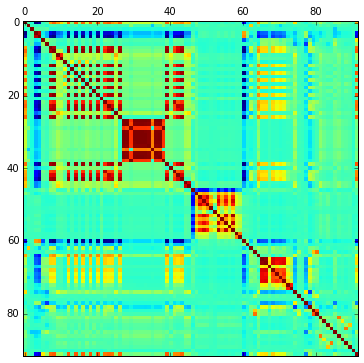

In [139]:
plt.matshow(data.corr())

There are significant groupings of the variables here. Remember that the explained variables are towards the end of the variable list:

In [140]:
data.columns[-10:]

Index(['# OUTPATIENT DEPT PROVIDER VISITS 13', '# EMERGENCY ROOM VISITS 13',
       '# NIGHTS IN HOSP FOR DISCHARGES 2013', 'FINAL PERSON WEIGHT 2013',
       'TOTAL OFFICE-BASED EXP 13', 'TOTAL OUTPATIENT PROVIDER EXP 13',
       'TOT HOSP IP FACILITY + DR EXP 13', 'TOTAL ER FACILITY + DR EXP 13',
       'CENSUS REGION AS OF 12/31/13', 'EDUCATION RECODE (EDITED)'],
      dtype='object')

and so the variables with index below 80 are all explanatory variables.

They seem to group into between 3 and 12 clusters of mutually positively correlated and negatively correlated sets of variables.

In order to build a model, we'll likely want to find ways to control the correlations between included explanatory variables in the dataset. This is independent of the requirement (for instance in linear regression analysis) that we check the the design matrix has full rank. Since we would like to build the most parsimonious model possible, we'll aim to have as few explanatory variables as possible explaining as much of the variance as possible. In linear regression analyses, this tendency is often encouraged by the practice of dropping variables with low p-values, whose estimated coefficients are not significantly different from zero. Including variables in the design matrix that are highly correlated tends to affect the robustness of their estimated coefficients. This practice of stabilizing the coefficient estimates, or sending them to zero, is often enforced by the technique of regularization (particularly $L_1$ regularization).

The correlation heatmap therefore suggests that our modeling process will likely involve a fair amount of dimensionality reduction. The precise way in which we accomplish this depends on the model we choose to build.

A typical choice of model for predicting continuous data is a regression (particularly linear regression) model, and it may well be the first model one tries to build.

A moment's (or rather, a few hours') thought might indicate otherwise, however.

The first problem with building a linear model for this dataset is the tremendous zero-clustering that we've seen. I include in this comment any model that is linear in its *basis functions*, which may include dummy variables, higher order polynomial, exponential, logarithmic, and otherwise transformed terms.

The primary problem with these models is that they tend to have support (in the sense of *support of a function*) over the entire real line. Which is to say, that they (given the right inputs) will output both negative and positive, and both large and small values in each direction.

The problem this poses for our dataset is clear: our explained variables are mostly concentrated around 0, and are never negative. (Who's ever been to the doctor and returned with more money in their pocket?)

Therefore, an important constraint we need to impose on our choice of model is that it always predict non-negative values. The second important constraint is that it should handle the zero-clustering in the dataset as well as possible.

There are some natural candidates for such a model. Generalized linear models (with log link functions) are a classical type of econometric model, used widely in the insurance and financial services industries. The specification of such a model is of the form:

$ln(y) = X\beta + \epsilon$

which makes clear that the predicted value for y is always (strictly) positive. The fact that this always outputs strictly positive estimates is problematic, but one workaround could be to simply bucket all values less than some threshold (say \$50) with 0.

This is not entirely satisfactory. For one thing, there is a great deal of arbitrariness in the choice of threshold, and it can be hard to justify the choice. (It may well be useful to select a threshold based on some prior - for instance, set it to be the minimum advertised cost of an encounter - but this requires its own analysis, and there may be very little data below this threshold to train on.)

Another candidate model may come from one of the approaches to [*censored regression*](https://en.wikipedia.org/wiki/Censored_regression_model), where the explained variable is not observed in certain situations. This is not quite the same as our issue, but it's akin to it. In our case, expenses of $\$0$ on healthcare result from a "failure" of the respondent to see a healthcare provider in that year (or to see one for more than covered preventative visits), and we may try interpret the expense of $\$0$ as a "censored value" in that record, in that we are unable to see what this person (or a person with similar characteristics in terms of our explanatory variables) would have spent if they had chosen to see a healthcare provider. This approach is not without its own objections, but building a simple Tobit regression model on this data could be an interesting exercise, and it's not always the case that techniques whose assumptions are not entirely justified by the dataset work terribly. A decent amount of modern machine learning takes the approach that it's best to do what works empirically rather than what is justified by the mathematics.

The fatal blow to my plans to Tobitize the heck out of this data was that there is not currently an implementation of Tobit regression in any Python module. The closest I found to something like this was a (currently) obscure development branch of the [statsmodels](https://github.com/statsmodels/statsmodels/blob/master/docs/source/about.rst) project, which claimed to have implemented something, but that had never been pulled to the master branch. Normally, I'd be game to work on implementing it myself, but there was no way this would happen during the Insight program, where there was hardly enough time to sleep as it was.

An alternative, since Tobit regression *is* implemented in R, would have been to use a Python->R API such as rpy2 to do my analysis. I'm not experience in R though, and time was running out for my Insight project (the next MVP deadline was imminent), and I decided to not fiddle with new syntax and API's with little time to learn or correct for errors.

At this point, I decided to forgo building a more classical econometric model in favor of trying something with more of a robust machine learning pedigree.

Of all the machine learning techniques I was acquainted with at the time, a random forest of regression trees seemed somewhat promising, and extremely practical. What with having a well written API and a (sufficiently, I assume) optimized implementation in the scikit-learn modules, I wouldn't need to write the routines from scratch myself (within two days, even) and could spend some time on feature engineering.

Some other options I considered were gradient boosted regressor trees, and a Bayesian regression model with ridge regularization. Both of these are implemented in scikit-learn, which is great. I did play with these for a while, but in the end decided to get started with the relatively easy-to-work-with random forest model, given time constraints. I remain quite fascinated by the Bayesian regression model as well as gradient boosting, and I intend to learn (and blog) more about them in due course.




Let's get down to building our model.

The first thing I want to do is to make a final decision about cleaning my dataset. 

Looking back at the univariate plots we've just made, there is relatively little mass in levels of categorical variables below -1 (which stands for inapplicable in the survey). These levels (-2,-7,-8,-9) refer to the cases where the response was determined previously, where the respondent refused to answer, did not know the answer, or the interviewer did not record the data. 

Arguments for dropping data points with levels less than -2 include that in our application, we expect a user to be able to either provide the required information about themselves, or select that it is inapplicable. In the case that they refuse to provide that piece of information, we can assume a uniform prior over the three levels (-1,1,2), and simply aggregate data over those three levels to provide the prediction. This will allow the user to see how the output becomes more precise as they provide more information, and also incorporates all the uncertainty inherent in the lack of user response. Finally, allowing our user to select response levels less than -1 for these variables will, due to the lack of mass in these levels, categorize him/her in a very sparsely populated bucket, which will both lead to unreliable predictions, as well as assume that the user is similar to a small number of users with highly idiosyncratic experiences.

However, a reasonable argument for leaving these data points in is that while there may a very small number of respondents in these categories, the number of respondents with high healthcare expenses is also very small, and we don't know *a priori* if there is any correlation between responses in these buckets and high healthcare expenses. Further, a random forest of regression trees can be estimated with practically no greater difficulty by leaving these levels in than taking them out, and it will be sufficient to simply not allow our users to respond with levels different from -1, 1 and 2 when they use the model to exclude the problem of associating their responses with low probability events, if that is what we choose to do.

Given this, I'm inclined to leave the data as is for now, and see if any interesting results come up in the modeling process.




The next step in the modeling process is to decide whether I want to engineer the features in some way.

Taking another look at the univariate plots above, one immediate problem is clear: while the categorical variables all have sigificant mass in the levels that we care about, the continuous variables (almost by definition) have very little mass for each level of the variable.

For example, in a dataset of about 35,000 people, it stands to reason that relatively few people will have the exact family income level of \$77,189. In fact, for some chosen level - say \$200,367.98 - there may be absolutely no data at that level. This makes the prediction task impossible.

A workaround for this is to transform the continuous explanatory variables by discretizing them into buckets, where the thresholds for the buckets are chosen so that each bucket has a reasonable amount of mass in it, to make the model estimation process more reliable.

For my project, I discretized the continuous variables as in the function below:



In [141]:
def bucket(regressor,value):
 if "ADULT" in regressor and "BODY" in regressor and "MASS" in regressor:
  return int((value>18.5)) + int((value > 24.9)) + int((value>29.9))
 if "AGE_OF_DIAGNOSIS" in regressor:
  return int((value>13)) + int((value>19)) + int((value>25)) + int((value>30)) + int((value>40)) + int((value>50)) + int((value>60)) 
 if "DIAG" in regressor and not ("AGE" in regressor):
  return int((value>0)) + int((value==1))
 if "AGE_AS_OF_" in regressor:
  return int((value>12)) + int((value>18)) + int((value>25)) + int((value>30)) + int((value>40)) + int((value>50)) + int((value>60))
 if "EDUCATION" in regressor:
  return int((value>0)) + int((value>1)) + int((value>2)) + int((value>13)) + int((value>14)) + int((value>15))
 if "PREGNANT" in regressor:
  return int((value>0)) + int((value==1))
 if "RACE" in regressor:
  return int((value>0)) + int((value>1)) + int((value>2)) + int((value>3)) + int((value>4))
 if "PERSON" in regressor and "INCOME" in regressor:
  return int((value>10000)) + int((value>35000)) + int((value>50000)) + int((value>70000)) + int((value>90000)) + int((value>120000)) + int((value>150000)) + int((value>200000))
 if "FAMILY" in regressor and "INCOME" in regressor:
  return int((value>18000)) + int((value>60000)) + int((value>90000)) + int((value>120000)) + int((value>150000)) + int((value>225000)) + int((value>400000)) 
 if "CENSUS" in regressor:
  return int((value>0)) + int((value>1)) + int((value>2)) + int((value>3))
 if "#" in regressor:
  return int((value>4)) + int((value>10)) + int((value>15)) + int((value>20)) + int((value>30)) + int((value>40)) + int((value>50))
 else:
  return value


A few words about these choices. I've discretized:

1. adult body mass index according to the [CDC guidelines for interpretation](http://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html#InterpretedAdults). The levels therefore correspond to: 
    1. Underweight
    2. Normal or Healthy Weight
    3. Overweight
    4. Obese
2.  family income according to federal tax brackets, to make user reporting easier, as well as to preserve user privacy when using the model
3. education level according to the following levels: (less than 8th grade, no high school diploma or GED, GED or high school grad, beyond high school including associate's degree, 4-year college degree or bachelor's degree, master's/doctorate/professional degree.
4. age variables according to the thresholds: (12,18,25,30,40,50,60,60+).

Below is the function I use to implement this discretization:
    

In [142]:
def bucketize(data,exog):
 for term in exog:
  data["%s_BUCKET"%term]=data[term].map(lambda x: bucket(term,x))
 return data

Of course, I only need to discretize continuous variables, whereas most of the variables in my list are already categorical.

One rough and ready way to break out the categorical variables is to check how many levels that feature has in the dataset - if there are relatively few (say below a threshold of 10 or 20), I'll assume the feature is categorical, and otherwise I'll assume it's continuous. Let's see if this works.

In [143]:
def check_discrete(data,thevariable):
    if len(data[thevariable].value_counts())>20:
        return "continuous"
    else:
        return "discrete"

Let's try this on a few variables to see if it works at all.

In [144]:
check_discrete(data,"FAMILY\'S TOTAL INCOME")

'continuous'

In [145]:
check_discrete(data,"HIGH BLOOD PRESSURE DIAG (>17)")

'discrete'

In [146]:
data=bucketize(data,variables)

In [229]:
data.head()

,AGE AS OF 12/31/13 (EDITED/IMPUTED),SEX,RACE (EDITED/IMPUTED),MARITAL STATUS-12/31/13 (EDITED/IMPUTED),MARITAL STATUS W/SPOUSE PRESENT-12/31/13,YEAR OF EDUCATION OR HIGHEST DEGREE,FAMILY'S TOTAL INCOME,HIGH BLOOD PRESSURE DIAG (>17),CORONARY HRT DISEASE DIAG (>17),AGE OF DIAGNOSIS-HIGH BLOOD PRESSURE,...,# OUTPATIENT DEPT PROVIDER VISITS 13_BUCKET,# EMERGENCY ROOM VISITS 13_BUCKET,# NIGHTS IN HOSP FOR DISCHARGES 2013_BUCKET,FINAL PERSON WEIGHT 2013_BUCKET,TOTAL OFFICE-BASED EXP 13_BUCKET,TOTAL OUTPATIENT PROVIDER EXP 13_BUCKET,TOT HOSP IP FACILITY + DR EXP 13_BUCKET,TOTAL ER FACILITY + DR EXP 13_BUCKET,CENSUS REGION AS OF 12/31/13_BUCKET,EDUCATION RECODE (EDITED)_BUCKET
0,39,1,1,1,1,5,85728,2,2,-1,...,0,0,0,6594.801768,428,0,0,0,3,4
1,40,2,1,1,1,4,85728,2,2,-1,...,0,0,0,7144.183132,0,0,0,0,3,3
2,10,2,1,6,3,1,85728,-1,-1,-1,...,0,0,0,5616.278666,0,108,0,0,3,1
3,52,1,1,4,2,5,20142,1,2,41,...,0,0,0,4045.586998,674,0,0,0,1,4
4,22,1,1,5,2,5,20142,2,2,-1,...,0,0,0,6901.505814,0,0,0,0,1,4


In [ ]:
def split_dataset(X,name):
 random=pd.DataFrame(np.random.uniform(0,1,len(X)))
 trainmask=random<.6
 testmask=(random<.8) & (random>=.6)
 validatemask=random>=.8
 X["train"]=trainmask.astype(int).copy()
 X["test"]=testmask.astype(int).copy()
 X["validate"]=validatemask.astype(int).copy()
 X.to_csv("./%s.csv"%name,index=False)
 X.to_pickle("./%s.pkl"%name)
 return X